<h1 align="center">Dise√±o e Implementaci√≥n de Modelo de Regresi√≥n usando FC-DNN</h1>

El objetivo es predecir las variables objetivo: "Valoraci√≥n general del teletrabajo", "Productividad en actual trabajo" y "Satisfacci√≥n en actual trabajo", en funci√≥n de las caracter√≠sticas de los dem√°s trabajadores, empleando aprendizaje autom√°tico profundo, concretamente, redes neuronales profundas totalmente conectadas.

### 1. Importar Librer√≠as:

In [1]:
# Manipulaci√≥n y Procesamiento de datos
import numpy as np
import pandas as pd

# Aprendizaje autom√°tico (profundo)
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Visualizaci√≥n de datos
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Generaci√≥n de datos para Campana de Gauss
from scipy.stats import norm

# Manejo de archivos
import xlsxwriter
import os

C:\Users\zorri\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\zorri\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
print("Versiones de las librer√≠as:")
print("- NumPy:", np.__version__)
print("- Pandas:", pd.__version__)

print("- Scikit-learn:", sklearn.__version__)
print("- TensorFlow:", tf.__version__)

print("- Matplotlib:", matplotlib.__version__)
print("- Seaborn:", sns.__version__)

print("- Xlsxwriter:", xlsxwriter.__version__)

Versiones de las librer√≠as:
- NumPy: 1.26.4
- Pandas: 2.2.3
- Scikit-learn: 1.6.1
- TensorFlow: 2.18.0
- Matplotlib: 3.4.3
- Seaborn: 0.11.2
- Xlsxwriter: 3.0.5


In [3]:
import sys
print("Python", sys.version)

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


### 2. Lectura del Dataset:

In [4]:
df_inicial = pd.read_excel("Trabajo_ Remoto vs Presencial (respuestas).xlsx")
df_inicial.head()

Marca temporal  ¬øCu√°l es tu edad? ¬øCu√°l es tu sexo?  \
0 2025-01-27 04:39:13.697                 22            Hombre   
1 2025-01-27 08:23:26.617                 41            Hombre   
2 2025-01-27 10:26:14.847                 22            Hombre   
3 2025-01-27 10:34:53.536                 22            Hombre   
4 2025-01-27 10:59:54.623                 23            Hombre   

  ¬øCu√°l es tu nacionalidad? ¬øCu√°l es tu nivel de estudios?  \
0                  Espa√±ola        Estudios universitarios   
1                  Espa√±ola          Estudios de postgrado   
2                  Espa√±ola        Estudios universitarios   
3                  Espa√±ola        Estudios universitarios   
4                  Espa√±ola        Estudios universitarios   

  ¬øEn qu√© sector trabajas?  \
0               Tecnolog√≠a   
1               Tecnolog√≠a   
2               Tecnolog√≠a   
3               Tecnolog√≠a   
4               Tecnolog√≠a   

   ¬øCu√°ntos a√±os de experiencia tiene en el entorno laboral?  \
0                                                1.5           
1                                               20.0           
2                                                2.0           
3                                                1.0           
4                                                1.0           

   ¬øCu√°ntas horas trabajas semanalmente?  \
0                                    8.0   
1                                   48.0   
2                                   30.0   
3                                   43.0   
4                                   40.0   

  ¬øCu√°l es la modalidad laboral en tu actual puesto de trabajo?  \
0                                            H√≠brido              
1                                             Remoto              
2                                            H√≠brido              
3                                             Remoto              
4                                            H√≠brido              

   ¬øC√≥mo describir√≠as tu opini√≥n actual sobre trabajar en remoto?  ...  \
0                                                  2               ...   
1                                                  2               ...   
2                                                  3               ...   
3                                                  3               ...   
4                                                  1               ...   

   ¬øC√≥mo ha afectado el trabajo en remoto a tu productividad laboral?  \
0                                                  2                    
1                                                  1                    
2                                                  2                    
3                                                  2                    
4                                                  2                    

   ¬øC√≥mo describir√≠as la comunicaci√≥n en remoto con los compa√±eros del trabajo?  \
0                                                  2                              
1                                                  1                              
2                                                  2                              
3                                                  2                              
4                                                  1                              

  ¬øC√≥mo ha afectado el trabajo en remoto a su bienestar general?  \
0                                                  2               
1                                                  3               
2                                                  3               
3                                                  2               
4                                                  2               

  ¬øQu√© modalidad laboral prefieres en el futuro?  \
0                                        H√≠brido   
1                                        H√≠brido   
2           

### 3. Preprocesamiento de datos:

In [5]:
df_inicial = df_inicial.drop(columns=['Marca temporal'])

# Crear la columna 'id'
df_inicial['id'] = range(1, len(df_inicial) + 1)

# Reorganizar las columnas para que 'id' sea la primera
df_inicial = df_inicial[['id'] + [col for col in df_inicial.columns if col != 'id']]

df_modif = df_inicial.rename(columns={'¬øCu√°l es tu edad?':'Edad', '¬øCu√°l es tu sexo?':'Sexo', '¬øCu√°l es tu nacionalidad?':'Nacionalidad', 
                       '¬øCu√°l es tu nivel de estudios?':'Nivel de estudios', '¬øEn qu√© sector trabajas?':'Sector laboral', 
                       '¬øCu√°ntos a√±os de experiencia tiene en el entorno laboral?':'A√±os de experiencia', 
                        '¬øCu√°ntas horas trabajas semanalmente?':'Horas de trabajo semanales', '¬øCu√°l es la modalidad laboral en tu actual puesto de trabajo?':'Modalidad laboral actual',
                       '¬øC√≥mo describir√≠as tu opini√≥n actual sobre trabajar en remoto?':'Opini√≥n actual de teletrabajo', '¬øC√≥mo calificar√≠as el trabajo 100% remoto?':'Calificaci√≥n trabajo remoto 100%',
                       '¬øCrees que el trabajo desde fuera de la oficina es aceptado en su sector?':'Aceptaci√≥n del trabajo en remoto en su sector', 
                       '¬øCu√°les dir√≠as que son las principales ventajas del trabajo en remoto? (Seleccione todas las opciones que creas necesarias)':'Ventajas teletrabajo',
                       '¬øCu√°les dir√≠as que son las principales desventajas del trabajo en remoto? (Seleccione todas las opciones que creas necesarias)':'Desventajas teletrabajo',
                       '¬øCu√°l es tu nivel de estr√©s?':'Nivel de estr√©s', '¬øQu√© condici√≥n de salud mental tienes? (Por ejemplo: ansiedad, depresi√≥n, "burnout", fatiga, etc.)':'Condici√≥n de salud mental',
                       '¬øCon qu√© frecuencia realiza actividad f√≠sica?':'Frecuencia de actividad f√≠sica', '¬øC√≥mo ha afectado el trabajo en remoto a tu productividad laboral?':'Efecto en productividad laboral del teletrabajo',
                       '¬øC√≥mo describir√≠as la comunicaci√≥n en remoto con los compa√±eros del trabajo?':'Comunicaci√≥n en remoto con compa√±eros',
                       '¬øC√≥mo ha afectado el trabajo en remoto a su bienestar general?':'Efecto en bienestar del teletrabajo', '¬øQu√© modalidad laboral prefieres en el futuro?':'Modalidad preferida',
                       '¬øCrees que el trabajo en remoto se consolidar√° en su sector a largo plazo?':'Consolidaci√≥n del teletrabajo en el sector',
                       '¬øCrees que se necesitan cambios para conseguir la sostenibilidad del trabajo en remoto? ':'Cambios para sostenibilidad teletrabajo',
                       'En el caso de que la anterior pregunta sea afirmativa, ¬øpor qu√© has elegido "S√≠" y qu√© cambios har√≠as?':'¬øQu√© debe cambiar?',
                       '¬øCu√°l dir√≠as que es tu nivel de productividad en tu actual puesto de trabajo?':'Productividad en actual trabajo', 
                       '¬øCu√°l dir√≠as que es tu nivel de satisfacci√≥n en tu actual puesto de trabajo?':'Satisfacci√≥n en actual trabajo'})

df_modif = df_modif.drop(columns=['Ventajas teletrabajo', 'Desventajas teletrabajo', '¬øQu√© debe cambiar?'])

print(df_modif.columns)
print(df_modif)

Index(['id', 'Edad', 'Sexo', 'Nacionalidad', 'Nivel de estudios',
       'Sector laboral', 'A√±os de experiencia', 'Horas de trabajo semanales',
       'Modalidad laboral actual', 'Opini√≥n actual de teletrabajo',
       'Calificaci√≥n trabajo remoto 100%',
       'Aceptaci√≥n del trabajo en remoto en su sector', 'Nivel de estr√©s',
       'Condici√≥n de salud mental', 'Frecuencia de actividad f√≠sica',
       'Efecto en productividad laboral del teletrabajo',
       'Comunicaci√≥n en remoto con compa√±eros',
       'Efecto en bienestar del teletrabajo', 'Modalidad preferida',
       'Consolidaci√≥n del teletrabajo en el sector',
       'Cambios para sostenibilidad teletrabajo',
       'Valoraci√≥n general del teletrabajo', 'Productividad en actual trabajo',
       'Satisfacci√≥n en actual trabajo'],
      dtype='object')
      id  Edad    Sexo Nacionalidad        Nivel de estudios  \
0      1    22  Hombre     Espa√±ola  Estudios universitarios   
1      2    41  Hombre     Espa√±ola 

In [6]:
df_modif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               370 non-null    int64  
 1   Edad                                             370 non-null    int64  
 2   Sexo                                             370 non-null    object 
 3   Nacionalidad                                     370 non-null    object 
 4   Nivel de estudios                                370 non-null    object 
 5   Sector laboral                                   370 non-null    object 
 6   A√±os de experiencia                              370 non-null    float64
 7   Horas de trabajo semanales                       370 non-null    float64
 8   Modalidad laboral actual                         370 non-null    object 
 9   Opini√≥n actual de teletrabajo 

#### 3.1. Reemplazo de los datos.

Debido a que se realiz√≥ una encuesta para la recopilaci√≥n de datos, se obtuvieron numerosas preguntas que abarcan un extenso abanico de respuestas, lo que implica la necesidad de procesar dichos datos.

##### 3.1.1. Nacionalidad.

In [7]:
# Obtener los valores √∫nicos de la columna 'Nacionalidad'
valores_unicos_nacionalidad = df_modif['Nacionalidad'].unique()
print(valores_unicos_nacionalidad)

['Espa√±ola' 'Colombiana ' 'Venezuela' 'Venezolana' 'Cubano' 'Cuba'
 'Cubana' 'Cubana ' 'cubana' 'American' 'Cubana y pronto espa√±ola'
 'La Havana, Cuba' 'Cubano ' 'cuba' 'Marroqu√≠' 'Cubana y espa√±ola'
 'Italiano' 'colombiana' 'Brasileira ' 'Ecuatoriano' 'Mexicana'
 'Colombiana' 'Argentina' 'CHILENA' 'Rumana ' 'Mexicana ' 'Dominicana '
 'Dominicana' 'Boliviana' 'Argentina espa√±ola' 'Ecuatoriana' 'Honduras'
 'Bolivia' 'peruano' 'Bolivia ' 'Peruana' 'Alem√°n' 'Portugal ' 'Mexicano '
 'El Salvador' 'Alemana']


In [8]:
# Crear un diccionario para mapear las nacionalidades originales a las nuevas (clave:valor)
mapeo_nacionalidades = {
    'Colombiana ': 'Colombiana',
    'Venezuela': 'Venezolana',
    'Cubano': 'Cubana',
    'Cuba': 'Cubana',
    'Cubana ': 'Cubana',
    'cubana': 'Cubana',
    'Cubano ': 'Cubana',
    'American': 'Americana',
    'Cubana y pronto espa√±ola': 'Cubana',
    'La Havana, Cuba': 'Cubana',
    'cuba': 'Cubana',
    'Cubana y espa√±ola': 'Cubana',
    'Italiano': 'Italiana',
    'colombiana': 'Colombiana',
    'Brasileira ': 'Brasile√±a',
    'Ecuatoriano': 'Ecuatoriana',
    'CHILENA': 'Chilena',
    'Rumana ': 'Rumana',
    'Mexicana ': 'Mexicana',
    'Dominicana ': 'Dominicana',
    'Argentina espa√±ola': 'Argentina',
    'Honduras': 'Hondure√±a',
    'Bolivia': 'Boliviana', 
    'Alem√°n': 'Alemana',
    'peruano': 'Peruana',
    'Bolivia ': 'Boliviana',
    'Portugal ': 'Portuguesa',
    'Mexicano ': 'Mexicana', 
    'El Salvador': 'Salvadore√±a'
}

# Modificar los registros de la columna 'Nacionalidad'
df_modif['Nacionalidad'] = df_modif['Nacionalidad'].replace(mapeo_nacionalidades)

# Obtener los valores √∫nicos de la columna 'Nacionalidad'
valores_unicos_nacionalidad = df_modif['Nacionalidad'].unique()
print(valores_unicos_nacionalidad)

['Espa√±ola' 'Colombiana' 'Venezolana' 'Cubana' 'Americana' 'Marroqu√≠'
 'Italiana' 'Brasile√±a' 'Ecuatoriana' 'Mexicana' 'Argentina' 'Chilena'
 'Rumana' 'Dominicana' 'Boliviana' 'Hondure√±a' 'Peruana' 'Alemana'
 'Portuguesa' 'Salvadore√±a']


##### 3.1.2. Nivel de estudios.

In [9]:
# Obtener los valores √∫nicos de la columna 'Nivel de estudios'
valores_unicos_estudios = df_modif['Nivel de estudios'].unique()
print(valores_unicos_estudios)

['Estudios universitarios' 'Estudios de postgrado' 'Formaci√≥n profesional'
 'Educaci√≥n secundaria' 'Doctorado' 'COU' 'Bachiller' 'Bachiller '
 'bachiller' 'Autodidacta' 'T√©cnico Bachiller'
 'Director de Ciberseguridad' 'Doctora en Econom√≠a' ' Bachillerato']


In [10]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Nivel de estudios'] = df_modif['Nivel de estudios'].str.strip()

# Crear un diccionario para mapear los niveles de estudio originales a las nuevas (clave:valor // key:value)
mapeo_estudios = {
    'Doctora en Econom√≠a': 'Doctorado',
    'COU': 'Educaci√≥n secundaria',
    'Bachiller': 'Bachillerato',
    'Bachiller ': 'Bachillerato',
    'bachiller': 'Bachillerato',
    'Autodidacta': 'Bachillerato',
    'T√©cnico Bachiller': 'Bachillerato',
    'Director de Ciberseguridad': 'Estudios universitarios'
}

# Modificar los registros de la columna 'Nivel de estudios'
df_modif['Nivel de estudios'] = df_modif['Nivel de estudios'].replace(mapeo_estudios)

# Obtener los valores √∫nicos de la columna 'Nivel de estudios'
valores_unicos_estudios = df_modif['Nivel de estudios'].unique()
print(valores_unicos_estudios)

['Estudios universitarios' 'Estudios de postgrado' 'Formaci√≥n profesional'
 'Educaci√≥n secundaria' 'Doctorado' 'Bachillerato']


##### 3.1.3. Sector laboral.

In [11]:
# Obtener los valores √∫nicos de la columna 'Sector laboral'
valores_unicos_sector = df_modif['Sector laboral'].unique()
print(valores_unicos_sector)

['Tecnolog√≠a' 'Servicios' 'Salud y Medicina' 'Funcionaria ' 'Inmobiliario'
 'Banca' 'Quimico ' 'Automoci√≥n ' 'Industria ' 'Automocion/Renting'
 'Marketing digital ' 'Educaci√≥n' 'Recursos humanos' 'COMERCIO'
 'Telemarketing ' 'Distribuci√≥n y exportaci√≥n ' 'tercer sector'
 'Administracion Local' 'Fotograf√≠a' 'Admon' 'Seguros' 'Consultor√≠a'
 'Logistica' 'Industria petrolera' 'Freelance' 'Agricultura '
 'Desarrollo web' 'marketing digital' 'Turismo'
 'Consultor√≠a y servicios inform√°ticos' 'Ciencia y tecnolog√≠a '
 'Comunicaci√≥n y Marketing ' 'Contabilidad'
 'Comunicaci√≥n social (Marketing)' 'Edici√≥n de video ' 'Empresarial '
 'Inform√°tica ' 'Marketing y dise√±o gr√°fico ' 'Estudio ' 'Ventas'
 'Marketing ' 'Administraci√≥n P√∫blica' 'Tercer sector'
 'Marketing, comunicaci√≥n ' 'Mercadeo ' 'Seguridad ' 'GRAN CONSUMO'
 'Master en Economia y Finanzas ' 'Organizaciones internacionales'
 'No trabajo' 'Marketing' 'Manufactura '
 'Actualmente no trabajo y necesito empleo' 'Dise√±o' 'I

In [12]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Sector laboral'] = df_modif['Sector laboral'].str.strip()

# Crear un diccionario para mapear los niveles de estudio originales a las nuevas (clave:valor // key:value)
mapeo_sector = {
    'Tecnolog√≠a': 'Tecnolog√≠a y Ciencia',
    'Desarrollo web': 'Tecnolog√≠a y Ciencia',
    'Consultor√≠a y servicios inform√°ticos': 'Tecnolog√≠a y Ciencia',
    'Edici√≥n de video': 'Tecnolog√≠a y Ciencia',
    'Inform√°tica': 'Tecnolog√≠a y Ciencia',
    'Ciencia y tecnolog√≠a': 'Tecnolog√≠a y Ciencia',
    'ingenier√≠a': 'Tecnolog√≠a y Ciencia',
    'Informatica': 'Tecnolog√≠a y Ciencia',
    'multimedia audiovisual': 'Tecnolog√≠a y Ciencia',
    'publicidasd': 'Tecnolog√≠a y Ciencia',
    'Tecnolog√≠a y audiovisual': 'Tecnolog√≠a y Ciencia',
    'Energia': 'Tecnolog√≠a y Ciencia',
    'Videojuegos': 'Tecnolog√≠a y Ciencia',
    
    'Farmac√©utica': 'Salud y Medicina',
    
    'Servicios': 'Servicios y Comercio',
    'Telemarketing': 'Servicios y Comercio',
    'Distribuci√≥n y exportaci√≥n': 'Servicios y Comercio',
    'COMERCIO': 'Servicios y Comercio',
    'GRAN CONSUMO': 'Servicios y Comercio',
    'Turismo': 'Servicios y Comercio',
    'Ventas': 'Servicios y Comercio',
    'Tercer sector': 'Servicios y Comercio',
    'tercer sector': 'Servicios y Comercio',
    'Mercadeo': 'Servicios y Comercio',
    'Ocio': 'Servicios y Comercio',
    'Seguridad': 'Servicios y Comercio',
    
    'Funcionaria': 'Administraci√≥n y Sector P√∫blico',
    'Administraci√≥n P√∫blica': 'Administraci√≥n y Sector P√∫blico',
    'Administracion Local': 'Administraci√≥n y Sector P√∫blico',
    'Admon': 'Administraci√≥n y Sector P√∫blico',
    'Administrativo': 'Administraci√≥n y Sector P√∫blico',
    'administracion y gestion': 'Administraci√≥n y Sector P√∫blico',
    
    
    'Banca': 'Finanzas y Negocios',
    'Contabilidad': 'Finanzas y Negocios',
    'Master en Economia y Finanzas': 'Finanzas y Negocios',
    'Empresarial': 'Finanzas y Negocios',
    'Seguros': 'Finanzas y Negocios',
    'Consultor√≠a': 'Finanzas y Negocios',
    'Inmobiliario': 'Finanzas y Negocios',
    'Organizaciones internacionales': 'Finanzas y Negocios',
    'Investigaci√≥n de mercados': 'Finanzas y Negocios',
    'Atenci√≥n al cliente y ventas': 'Finanzas y Negocios',
    'Servicio legales': 'Finanzas y Negocios',
    'Econom√≠a y empresa': 'Finanzas y Negocios',
    
    'Marketing digital': 'Marketing y Comunicaci√≥n',
    'marketing digital': 'Marketing y Comunicaci√≥n',
    'Comunicaci√≥n y Marketing': 'Marketing y Comunicaci√≥n',
    'Comunicaci√≥n social (Marketing)': 'Marketing y Comunicaci√≥n',
    'Marketing, comunicaci√≥n': 'Marketing y Comunicaci√≥n',
    'Publicidad': 'Marketing y Comunicaci√≥n',
    'Dise√±o': 'Marketing y Comunicaci√≥n',
    'Marketing y dise√±o gr√°fico': 'Marketing y Comunicaci√≥n',
    'Fotograf√≠a': 'Marketing y Comunicaci√≥n',
    'Marketing': 'Marketing y Comunicaci√≥n',
    'marketing': 'Marketing y Comunicaci√≥n',
    'Comunicaci√≥n': 'Marketing y Comunicaci√≥n',
    'Dise√±o y comunicaci√≥n': 'Marketing y Comunicaci√≥n',
    
    
    'Quimico': 'Industria y Manufactura',
    'Automoci√≥n': 'Industria y Manufactura',
    'Automocion/Renting': 'Industria y Manufactura',
    'Industria': 'Industria y Manufactura',
    'Industria petrolera': 'Industria y Manufactura',
    'Manufactura': 'Industria y Manufactura',
    
    'Agricultura': 'Agricultura y Medio Ambiente',
    
    'RRHH': 'Recursos Humanos',
    'Recursos humanos': 'Recursos Humanos',
    'Ciencias sociales (Recursos Humanos)': 'Recursos Humanos'
}

df_modif = df_modif[~df_modif['Sector laboral'].isin(['No trabajo', 'Actualmente no trabajo y necesito empleo', 'Estudio', 'estudiante', 'Estudiante'])]  # Eliminar registros donde no se trabaje

# Modificar los registros de la columna 'Sector laboral'
df_modif['Sector laboral'] = df_modif['Sector laboral'].replace(mapeo_sector)

# Obtener los valores √∫nicos de la columna 'Sector laboral'
valores_unicos_sector = df_modif['Sector laboral'].unique()
print(valores_unicos_sector)

['Tecnolog√≠a y Ciencia' 'Servicios y Comercio' 'Salud y Medicina'
 'Administraci√≥n y Sector P√∫blico' 'Finanzas y Negocios'
 'Industria y Manufactura' 'Marketing y Comunicaci√≥n' 'Educaci√≥n'
 'Recursos Humanos' 'Logistica' 'Freelance' 'Agricultura y Medio Ambiente'
 'Investigaci√≥n' 'Cooperaci√≥n internacional' 'Traducci√≥n' 'Deportes']


##### 3.1.4. Condici√≥n de salud mental.

In [13]:
# Obtener los valores √∫nicos de la columna 'Condici√≥n de salud mental'
valores_unicos_saludmental = df_modif['Condici√≥n de salud mental'].unique()
print(valores_unicos_saludmental)

[nan 'Burnout' 'Ansiedad y fatiga '
 'Intento separar correctamente, mi vida laboral con mi vida personal'
 'Sana ' 'No' 'Sana' 'Ansiedad' 'Ansiedad ' 'Es correcta mi salud mental'
 'Ninguna ' 'N/a' 'Fatiga ' 'Estres' 'A veces algo de stress' 'Ninguna'
 'Buena' 'Rumiacion' 'Fatiga' 'Ninguno ' 'Sana gracias a Dios ' 'Normal'
 'Andiedad' 'Cansancio' 'Ninguno' 'Ansiedad, fatiga '
 'Salud mental equilibrada ' 'ahora mismo ninguno de los descritos'
 'Normal '
 'Ansiedad, Burnout (en mi anterior puesto ve trabajo). Actualmente quiz√°s estr√©s por cierto compa√±ero pero por lo dem√°s todo bien '
 'ninguna' 'burnout' 'ansiedad' 'Estr√©s ' 'Depresi√≥n y Ansiedad ' 'normal'
 'Me siento bien ' 'Estable' '-'
 'Picos de ansiedad en momentos de alta carga de trabajo.' 'Nada'
 'No tengo' 'ansiedad ' 'Por ahora ninguna'
 'Se lidiar con el est√©s es parte del d√≠a a d√≠a de un programador '
 'Fuerte' 'estable' 'nada' 'Estoy perfectamente bien ' 'depresi√≥n'
 'me siento bien en general' 'Buen estado ' '

In [14]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Condici√≥n de salud mental'] = df_modif['Condici√≥n de salud mental'].str.strip()

# Crear un diccionario para mapear las condiciones de salud mental originales a las nuevas (clave:valor // key:value)
mapeo_saludmental = {
    'Ansiedad y fatiga': 'Fatiga',
    'Intento separar correctamente, mi vida laboral con mi vida personal': 'Sin problema espec√≠fico',
    'Sana ': 'Sin problema espec√≠fico',
    'No': 'Sin problema espec√≠fico',
    'Sana': 'Sin problema espec√≠fico',
    'Ansiedad ': 'Ansiedad',
    'Es correcta mi salud mental': 'Sin problema espec√≠fico',
    'Ninguna ': 'Sin problema espec√≠fico',
    'N/a': 'Sin problema espec√≠fico',
    'Fatiga ': 'Fatiga',
    'Estres': 'Estr√©s',
    'A veces algo de stress': 'Estr√©s',
    'Ninguna': 'Sin problema espec√≠fico',
    'Buena': 'Sin problema espec√≠fico',
    'Rumiacion': 'Sin problema espec√≠fico',
    'Ninguno ': 'Sin problema espec√≠fico',
    'Sana gracias a Dios': 'Sin problema espec√≠fico',
    'Normal': 'Sin problema espec√≠fico',
    'Andiedad': 'Ansiedad',
    'Cansancio': 'Cansancio',
    'Ninguno': 'Sin problema espec√≠fico',
    'Ansiedad, fatiga': 'Ansiedad y Fatiga',
    'Salud mental equilibrada ': 'Sin problema espec√≠fico',
    'ahora mismo ninguno de los descritos': 'Sin problema espec√≠fico',
    'Normal ': 'Sin problema espec√≠fico',
    'Ansiedad, Burnout (en mi anterior puesto ve trabajo). Actualmente quiz√°s estr√©s por cierto compa√±ero pero por lo dem√°s todo bien': 'Estr√©s',
    'ninguna': 'Sin problema espec√≠fico',
    'burnout': 'Burnout',
    'ansiedad': 'Ansiedad',
    'Estr√©s ': 'Estr√©s',
    'Depresi√≥n y Ansiedad ': 'Depresi√≥n y Ansiedad',
    'normal': 'Sin problema espec√≠fico',
    'Me siento bien ': 'Sin problema espec√≠fico',
    'Estable': 'Sin problema espec√≠fico',
    '-': 'Sin problema espec√≠fico',
    'Picos de ansiedad en momentos de alta carga de trabajo.': 'Ansiedad',
    'Nada': 'Sin problema espec√≠fico',
    'No tengo': 'Sin problema espec√≠fico',
    'ansiedad ': 'Ansiedad',
    'Por ahora ninguna': 'Sin problema espec√≠fico',
    'Se lidiar con el est√©s es parte del d√≠a a d√≠a de un programador': 'Estr√©s',
    'Fuerte': 'Sin problema espec√≠fico',
    'estable': 'Sin problema espec√≠fico',
    'nada': 'Sin problema espec√≠fico',
    'Estoy perfectamente bien ': 'Sin problema espec√≠fico',
    'depresi√≥n': 'Depresi√≥n',
    'me siento bien en general': 'Sin problema espec√≠fico',
    'Buen estado ': 'Sin problema espec√≠fico',
    'Saludable': 'Sin problema espec√≠fico',
    'buena': 'Sin problema espec√≠fico',
    'Ninguna negativa': 'Sin problema espec√≠fico',
    'Ansiedad üò∞': 'Ansiedad',
    'Depresi√≥n ': 'Depresi√≥n',
    'Ninguni': 'Sin problema espec√≠fico',
    'Sano': 'Sin problema espec√≠fico',
    'No procede': 'Sin problema espec√≠fico',
    'fatiga': 'Fatiga',
    'Ansiedad leve': 'Ansiedad',
    'Mi salud mental est√° en perfecto estado': 'Sin problema espec√≠fico',
    'No presento ninguna enfermedad ': 'Sin problema espec√≠fico',
    'No tengo ningua aflicci√≥n particular, me siento en condiciones y deseos de superarme': 'Sin problema espec√≠fico',
    'Ninguna de las anteriores ': 'Sin problema espec√≠fico',
    'No tengo problemas de salud mental': 'Sin problema espec√≠fico',
    'Falta de paciencia': 'Estr√©s',
    'Agobio': 'Estr√©s',
    'ansiedad\n': 'Ansiedad',
    'Estable pero con periodos de ansiedad moderada': 'Ansiedad',
    'Espor√°dicamente ansiedad y depresi√≥n leve. Actualmente estoy en un muy buen momento para mi salud.': 'Ansiedad y Depresi√≥n',
    'Ansiedad y burnout': 'Ansiedad y Burnout',
    'Ansiedad en algunas ocasiones': 'Ansiedad',
    'Ansiedad eventual, crisis existenciales espor√°dicas': 'Ansiedad',
    'Nada, estoy bien satisfecho con mi trabajo y mi vida personal, tengo varias metas y me siento enfocado en el constante aprendizaje': 'Sin problema espec√≠fico',
    'fatiga ': 'Fatiga',
    'No tengo condiciones de salud mental': 'Sin problema espec√≠fico',
    'Ansiedad y depresion': 'Ansiedad y Depresi√≥n',
    'Ninguna de las anteriores': 'Sin problema espec√≠fico',
    'Estoy perfectamente bien': 'Sin problema espec√≠fico',
    'Me siento bien': 'Sin problema espec√≠fico',
    'Buen estado': 'Sin problema espec√≠fico',
    'Salud mental equilibrada': 'Sin problema espec√≠fico',
    'No presento ninguna enfermedad': 'Sin problema espec√≠fico',
    'Ningna': 'Sin problema espec√≠fico',
    'Ansiedad (no laboral)': 'Ansiedad',
    'm√≠nimo estr√©s de trabajo': 'Estr√©s',
    'No sufro de ninguno, pero el trabajar + estudiar desgasta mucho.': 'Sin problema espec√≠fico',
    'Depresi√≥n, adicciones': 'Depresi√≥n',
    'ninguno': 'Sin problema espec√≠fico',
    'depresi√≥n': 'Depresi√≥n',
    'Ansiedad y depresi√≥n diagnosticadas': 'Ansiedad y Depresi√≥n',
    'estr√©s': 'Estr√©s',
    'No tengo mente ni emociones, as√≠ que no puedo tener una condici√≥n de salud mental.': 'Sin problema espec√≠fico',
    'Bornout': 'Burnout',
    'ansiedad estres': 'Ansiedad y Estr√©s',
    'Ansiedad y depresi√≥n': 'Ansiedad y Depresi√≥n',
    'estres, fatiga': 'Fatiga',
    'Calmado': 'Sin problema espec√≠fico',
    'ansiedad y burnout': 'Ansiedad y Burnout',
    'Trastorno bipolar, TLP y TCA': 'Otros',
    'depresi√≥n, ocd, tdah': 'Otros',
    'Insomnio cr√≥nico': 'Otros',
}

# Modificar los registros de la columna 'Condici√≥n de salud mental'
df_modif['Condici√≥n de salud mental'] = df_modif['Condici√≥n de salud mental'].replace(mapeo_saludmental)

# Sustituir los valores nulos por 'Sin problema espec√≠fico'
df_modif['Condici√≥n de salud mental'] = df_modif['Condici√≥n de salud mental'].fillna('Sin problema espec√≠fico')

# Obtener los valores √∫nicos de la columna 'Condici√≥n de salud mental'
valores_unicos_saludmental = df_modif['Condici√≥n de salud mental'].unique()
print(valores_unicos_saludmental)


['Sin problema espec√≠fico' 'Burnout' 'Fatiga' 'Ansiedad' 'Estr√©s'
 'Cansancio' 'Ansiedad y Fatiga' 'Depresi√≥n y Ansiedad' 'Depresi√≥n'
 'Ansiedad y Depresi√≥n' 'Ansiedad y Burnout' 'Otros' 'Ansiedad y Estr√©s']


##### 3.1.5. Frecuencia de actividad f√≠sica.

In [15]:
# Obtener los valores √∫nicos de la columna 'Frecuencia de actividad f√≠sica'
valores_unicos_actividad = df_modif['Frecuencia de actividad f√≠sica'].unique()
print(valores_unicos_actividad)

['Semanalmente' 'Rara vez' 'Diariamente' '3//4 veces a la semana '
 'Un d√≠a a la semana ' '4 a 5 veces a la semana' '3 o 4 d√≠as a la semana '
 'No solo realizo actividad f√≠sica regular, soy practicante avanzado de varias artes marciales'
 '3 veces a la semana' '3 veces por semana ' 'de 3 a 4 veces por semana '
 '4 veces por semana']


In [16]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Frecuencia de actividad f√≠sica'] = df_modif['Frecuencia de actividad f√≠sica'].str.strip()

# Crear un diccionario para mapear la frecuencia de activididad f√≠sica originales a las nuevas (clave:valor)
mapeo_actividad = {
    'Rara vez': 'E. Rara vez',
    'Semanalmente': 'D. 1 d√≠a a la semana',
    'Un d√≠a a la semana': 'D. 1 d√≠a a la semana',
    '3 o 4 d√≠as a la semana': 'C. 3 o 4 d√≠as a la semana',
    '3//4 veces a la semana': 'C. 3 o 4 d√≠as a la semana',
    'No solo realizo actividad f√≠sica regular, soy practicante avanzado de varias artes marciales': 'C. 3 o 4 d√≠as a la semana',
    '4 a 5 veces a la semana': 'B. 4 o 5 d√≠as a la semana',
    'Diariamente': 'A. Diariamente',
    '3 veces a la semana': 'C. 3 o 4 d√≠as a la semana',
    '3 veces por semana': 'C. 3 o 4 d√≠as a la semana',
    'de 3 a 4 veces por semana': 'C. 3 o 4 d√≠as a la semana',
    '4 veces por semana': 'B. 4 o 5 d√≠as a la semana'
}

# Modificar los registros de la columna 'Frecuencia de actividad f√≠sica'
df_modif['Frecuencia de actividad f√≠sica'] = df_modif['Frecuencia de actividad f√≠sica'].replace(mapeo_actividad)

# Obtener los valores √∫nicos de la columna 'Frecuencia de actividad f√≠sica'
valores_unicos_actividad = df_modif['Frecuencia de actividad f√≠sica'].unique()
print(valores_unicos_actividad)

['D. 1 d√≠a a la semana' 'E. Rara vez' 'A. Diariamente'
 'C. 3 o 4 d√≠as a la semana' 'B. 4 o 5 d√≠as a la semana']


##### 3.1.6. Nivel de estr√©s.

In [17]:
# Obtener los valores √∫nicos de la columna 'Nivel de estr√©s'
valores_unicos_estres = df_modif['Nivel de estr√©s'].unique()
print(valores_unicos_estres)

['Medio' 'Bajo' 'Alto' 'Ninguno']


In [18]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Nivel de estr√©s'] = df_modif['Nivel de estr√©s'].str.strip()

# Crear un diccionario para mapear la frecuencia de activididad f√≠sica originales a las nuevas (clave:valor)
mapeo_estres = {
    'Alto': 'A. Alto',
    'Medio': 'B. Medio',
    'Bajo': 'C. Bajo',
    'Ninguno': 'D. Ninguno'
}

# Modificar los registros de la columna 'Frecuencia de actividad f√≠sica'
df_modif['Nivel de estr√©s'] = df_modif['Nivel de estr√©s'].replace(mapeo_estres)

# Obtener los valores √∫nicos de la columna 'Frecuencia de actividad f√≠sica'
valores_unicos_estres = df_modif['Nivel de estr√©s'].unique()
print(valores_unicos_estres)

['B. Medio' 'C. Bajo' 'A. Alto' 'D. Ninguno']


In [19]:
print(df_modif.info())

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               365 non-null    int64  
 1   Edad                                             365 non-null    int64  
 2   Sexo                                             365 non-null    object 
 3   Nacionalidad                                     365 non-null    object 
 4   Nivel de estudios                                365 non-null    object 
 5   Sector laboral                                   365 non-null    object 
 6   A√±os de experiencia                              365 non-null    float64
 7   Horas de trabajo semanales                       365 non-null    float64
 8   Modalidad laboral actual                         365 non-null    object 
 9   Opini√≥n actual de teletrabajo      

#### 3.2. Transformaci√≥n de las variables categ√≥ricas a num√©ricas.

Esta transformaci√≥n es necesaria para que el modelo interprete e identifique patrones en los datos de manera correcta, ya que, al trabajar con datos categ√≥ricos no se pueden llevar a cabo c√°lculos matem√°ticos.

##### 3.2.1. LabelEncoder.

El m√©todo LabelEncoder asigna a cada categor√≠a un valor num√©rico √∫nico, concretamente un valor entero que puede tomar de 0 a 9 d√≠gitos. Adem√°s, se introduce un orden jer√°rquico clave en la transformaci√≥n de las siguientes caracter√≠sticas: 'Nivel de estr√©s' y 'Frecuencia de actividad f√≠sica'.

In [20]:
# Lista de columnas categ√≥ricas
columnas_categoricas_labelEncoding = ['Nivel de estr√©s', 'Frecuencia de actividad f√≠sica', 'Opini√≥n actual de teletrabajo', 
                                      'Comunicaci√≥n en remoto con compa√±eros', 'Consolidaci√≥n del teletrabajo en el sector']

# Diccionario para almacenar los LabelEncoders para cada columna y los mapeos de cada una
label_encoders = {}
mapeo_clases_labelEncoding = {}

# Aplicar Labelencoder a cada columna categ√≥rica
for columna in columnas_categoricas_labelEncoding:
    le = LabelEncoder()
    df_modif[columna] = le.fit_transform(df_modif[columna])
    label_encoders[columna] = le # Guardar el codificador para usos posteriores
    
    # Guardar el mapeo con la categor√≠a y el n√∫mero como estructura "clave:valor"
    mapeo_clases_labelEncoding[columna] = {class_name: index for index, class_name in enumerate(le.classes_)}
    
    # Invertir el mapeo, asignar n√∫meros en orden inverso
    mapeo = {class_name: len(le.classes_) - 1 - index for index, class_name in enumerate(le.classes_)}
    mapeo_clases_labelEncoding[columna] = mapeo

    # Aplicar el mapeo invertido a la columna
    df_modif[columna] = df_modif[columna].map({v: k for k, v in mapeo.items()}).map(mapeo)
    
# Imprimir los mapeos de clases para cada columna
for column, mapping in mapeo_clases_labelEncoding.items():
    print(f"\033[1m{columna}\033[0m: {mapping}")
    
# LabelEncoder info: https://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.LabelEncoder.html
# Bold text: https://www.kodeclik.com/how-to-bold-text-in-python/

Nivel de estr√©s: {'A. Alto': 3, 'B. Medio': 2, 'C. Bajo': 1, 'D. Ninguno': 0}
Frecuencia de actividad f√≠sica: {'A. Diariamente': 4, 'B. 4 o 5 d√≠as a la semana': 3, 'C. 3 o 4 d√≠as a la semana': 2, 'D. 1 d√≠a a la semana': 1, 'E. Rara vez': 0}
Opini√≥n actual de teletrabajo: {1: 2, 2: 1, 3: 0}
Comunicaci√≥n en remoto con compa√±eros: {1: 2, 2: 1, 3: 0}
Consolidaci√≥n del teletrabajo en el sector: {'No': 1, 'S√≠': 0}


In [21]:
df_modif.head(5)

id  Edad    Sexo Nacionalidad        Nivel de estudios  \
0   1    22  Hombre     Espa√±ola  Estudios universitarios   
1   2    41  Hombre     Espa√±ola    Estudios de postgrado   
2   3    22  Hombre     Espa√±ola  Estudios universitarios   
3   4    22  Hombre     Espa√±ola  Estudios universitarios   
4   5    23  Hombre     Espa√±ola  Estudios universitarios   

         Sector laboral  A√±os de experiencia  Horas de trabajo semanales  \
0  Tecnolog√≠a y Ciencia                  1.5                         8.0   
1  Tecnolog√≠a y Ciencia                 20.0                        48.0   
2  Tecnolog√≠a y Ciencia                  2.0                        30.0   
3  Tecnolog√≠a y Ciencia                  1.0                        43.0   
4  Tecnolog√≠a y Ciencia                  1.0                        40.0   

  Modalidad laboral actual  Opini√≥n actual de teletrabajo  ...  \
0                  H√≠brido                              1  ...   
1                   Remoto                              1  ...   
2                  H√≠brido                              2  ...   
3                   Remoto                              2  ...   
4                  H√≠brido                              0  ...   

   Frecuencia de actividad f√≠sica  \
0                               3   
1                               3   
2                               3   
3                               4   
4                               3   

   Efecto en productividad laboral del teletrabajo  \
0                                                2   
1                                                1   
2                                                2   
3                                                2   
4                                                2   

   Comunicaci√≥n en remoto con compa√±eros Efecto en bienestar del teletrabajo  \
0                                      1                                   2   
1                                      0                                   3   
2                                      1                                   3   
3                                      1                                   2   
4                                      0                                   2   

   Modalidad preferida  Consolidaci√≥n del teletrabajo en el sector  \
0              H√≠brido                                           1   
1              H√≠brido                                           1   
2              H√≠brido                                           0   
3              H√≠brido                                           1   
4      Presencial 100%                                           0   

   Cambios para sostenibilidad teletrabajo  \
0                                       No   
1                                       S√≠   
2                                       No   
3                                       S√≠   
4                                       S√≠   

   Valoraci√≥n general del teletrabajo Productividad en actual trabajo  \
0                                 NaN                             NaN   
1                                 NaN                             NaN   
2                                 NaN                             NaN   
3                                 NaN                             NaN   
4                                 NaN                             NaN   

   Satisfacci√≥n en actual trabajo  
0                             NaN  
1                             NaN  
2                             NaN  
3                             NaN  
4                             NaN  

[5 rows x 24 columns]

In [22]:
df_original = df_modif.copy()
df_original.head()
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               365 non-null    int64  
 1   Edad                                             365 non-null    int64  
 2   Sexo                                             365 non-null    object 
 3   Nacionalidad                                     365 non-null    object 
 4   Nivel de estudios                                365 non-null    object 
 5   Sector laboral                                   365 non-null    object 
 6   A√±os de experiencia                              365 non-null    float64
 7   Horas de trabajo semanales                       365 non-null    float64
 8   Modalidad laboral actual                         365 non-null    object 
 9   Opini√≥n actual de teletrabajo      

##### 3.2.2. One-Hot Encoding.

El m√©todo One-Hot Encoding asigna a cada categor√≠a un valor binario √∫nico (0s y 1s). No se introduce un orden jer√°rquico, siendo crucial para que cada neurona pueda aprender de manera independiente.

In [23]:
# Lista de columnas categ√≥ricas
columnas_categoricas_onehotEncoding = [
    'Sexo', 'Nacionalidad', 'Nivel de estudios', 'Sector laboral', 
    'Modalidad laboral actual', 'Condici√≥n de salud mental', 
    'Modalidad preferida', 'Cambios para sostenibilidad teletrabajo'
]

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Transformar las columnas categ√≥ricas
encoded_data = onehot_encoder.fit_transform(df_modif[columnas_categoricas_onehotEncoding])

# Obtener los nombres de las nuevas columnas usando get_feature_names_out
columnas_onehot = onehot_encoder.get_feature_names_out(columnas_categoricas_onehotEncoding)

# Crear un DataFrame con los datos codificados
df_encoded = pd.DataFrame(encoded_data, columns=columnas_onehot, index=df_modif.index)

# Combinar el DataFrame codificado con el DataFrame original y eliminar las columnas originales
df_modif = pd.concat([df_modif.drop(columns=columnas_categoricas_onehotEncoding), df_encoded], axis=1)

print(f"Columnas creadas con One Hot Encoding: {list(df_encoded.columns)}")

Columnas creadas con One Hot Encoding: ['Sexo_Hombre', 'Sexo_Mujer', 'Nacionalidad_Alemana', 'Nacionalidad_Americana', 'Nacionalidad_Argentina', 'Nacionalidad_Boliviana', 'Nacionalidad_Brasile√±a', 'Nacionalidad_Chilena', 'Nacionalidad_Colombiana', 'Nacionalidad_Cubana', 'Nacionalidad_Dominicana', 'Nacionalidad_Ecuatoriana', 'Nacionalidad_Espa√±ola', 'Nacionalidad_Hondure√±a', 'Nacionalidad_Italiana', 'Nacionalidad_Marroqu√≠', 'Nacionalidad_Mexicana', 'Nacionalidad_Peruana', 'Nacionalidad_Portuguesa', 'Nacionalidad_Rumana', 'Nacionalidad_Venezolana', 'Nivel de estudios_Bachillerato', 'Nivel de estudios_Doctorado', 'Nivel de estudios_Educaci√≥n secundaria', 'Nivel de estudios_Estudios de postgrado', 'Nivel de estudios_Estudios universitarios', 'Nivel de estudios_Formaci√≥n profesional', 'Sector laboral_Administraci√≥n y Sector P√∫blico', 'Sector laboral_Agricultura y Medio Ambiente', 'Sector laboral_Cooperaci√≥n internacional', 'Sector laboral_Deportes', 'Sector laboral_Educaci√≥n', 'Se

In [24]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Data columns (total 64 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Sexo_Hombre                                        365 non-null    float64
 1   Sexo_Mujer                                         365 non-null    float64
 2   Nacionalidad_Alemana                               365 non-null    float64
 3   Nacionalidad_Americana                             365 non-null    float64
 4   Nacionalidad_Argentina                             365 non-null    float64
 5   Nacionalidad_Boliviana                             365 non-null    float64
 6   Nacionalidad_Brasile√±a                             365 non-null    float64
 7   Nacionalidad_Chilena                               365 non-null    float64
 8   Nacionalidad_Colombiana                            365 non-null    float64
 9   Nacionalidad_C

In [25]:
# Crear un nuevo DataFrame

# PASO 1: Seleccionar las columnas num√©ricas de "df_modif"
df_modif_numeric = df_modif.select_dtypes(include=['number'])


#PASO 2: Concatenar los DataFrames
df_nuevo = pd.concat([df_encoded, df_modif_numeric], axis=1)

df_nuevo.head()

Sexo_Hombre  Sexo_Mujer  Nacionalidad_Alemana  Nacionalidad_Americana  \
0          1.0         0.0                   0.0                     0.0   
1          1.0         0.0                   0.0                     0.0   
2          1.0         0.0                   0.0                     0.0   
3          1.0         0.0                   0.0                     0.0   
4          1.0         0.0                   0.0                     0.0   

   Nacionalidad_Argentina  Nacionalidad_Boliviana  Nacionalidad_Brasile√±a  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   Nacionalidad_Chilena  Nacionalidad_Colombiana  Nacionalidad_Cubana  ...  \
0                   0.0                      0.0                  0.0  ...   
1                   0.0                      0.0                  0.0  ...   
2                   0.0                      0.0                  0.0  ...   
3                   0.0                      0.0                  0.0  ...   
4                   0.0                      0.0                  0.0  ...   

   Condici√≥n de salud mental_Depresi√≥n y Ansiedad  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   

   Condici√≥n de salud mental_Estr√©s  Condici√≥n de salud mental_Fatiga  \
0                               0.0                               0.0   
1                               0.0                               0.0   
2                               0.0                               0.0   
3                               0.0                               0.0   
4                               0.0                               0.0   

   Condici√≥n de salud mental_Otros  \
0                              0.0   
1                              0.0   
2                              0.0   
3                              0.0   
4                              0.0   

   Condici√≥n de salud mental_Sin problema espec√≠fico  \
0                                                1.0   
1                                                0.0   
2                                                1.0   
3                                                1.0   
4                                                1.0   

   Modalidad preferida_H√≠brido  Modalidad preferida_Presencial 100%  \
0                          1.0                                  0.0   
1                          1.0                                  0.0   
2                          1.0                                  0.0   
3                          1.0                                  0.0   
4                          0.0                                  1.0   

   Modalidad preferida_Remoto 100%  \
0                              0.0   
1                              0.0   
2                              0.0   
3                              0.0   
4                              0.0   

   Cambios para sostenibilidad teletrabajo_No  \
0                                         1.0   
1                                         0.0   
2                                         1.0   
3                                         0.0   
4                                         0.0   

   Cambios para sostenibilidad teletrabajo_S√≠  
0                                         0.0  
1                                         1.0  
2                                         0.0  
3                                         1.0  
4                                         1.0  

[5 rows x 144 columns]

In [26]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Columns: 144 entries, Sexo_Hombre to Cambios para sostenibilidad teletrabajo_S√≠
dtypes: float64(133), int64(11)
memory usage: 413.5 KB


### 4. Desarrollo de la FC-DNN:

#### 4.1. Dise√±o de la arquitectura de la red neuronal.

In [27]:
# Definir las variables objetivo
variables_objetivo = ['Valoraci√≥n general del teletrabajo', 'Productividad en actual trabajo', 'Satisfacci√≥n en actual trabajo']

In [28]:
# Separar el dataset en registros con datos completos y aquellos con valores nulos en las variables objetivo
df_train = df_nuevo.dropna(subset=variables_objetivo)
df_pred = df_nuevo[df_nuevo[variables_objetivo].isna().all(axis=1)]

In [29]:
# Identificar las caracter√≠sticas
cols_caracteristicas = [col for col in df_nuevo.columns if col not in variables_objetivo and col != "id"]

In [30]:
# Preprocesar el conjunto de entrenamiento
X = df_train[cols_caracteristicas].copy()
y = df_train[variables_objetivo].copy()

In [31]:
# Comprobar que tanto "X" como "y" tienen la misma forma
# El valor 114 hace referencia a los registros, donde los valores en las variables objetivo est√°n presentes
# El valor 268 corresponde al n√∫mero de columnas del dataset que se est√°n utilizando como caracter√≠sticas
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (114, 268)
y shape: (114, 3)


In [32]:
# Escalar las caracter√≠sticas para facilitar el aprendizaje de la red neuronal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
# Funci√≥n para crear la red neuronal
def crear_fcdnn():
    
    # Factor de regularizaci√≥n L2
    regularizacion = l2(0.0000001)
   
    # Tasa de dropout
    tasa_dropout = 0.005
    
    model = Sequential([
        tf.keras.Input(shape=(X_scaled.shape[1],)), # Capa de entrada 
        
        # Capas ocultas con determinada cantidad de neuronas
        
        Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),
        
        Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),    
        
        Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),
        
        Dense(32, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),
        
        
        # Capa de salida: 3 neuronas para las 3 variables objetivo de salida
        Dense(3, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

#### 4.2. Validaci√≥n cruzada con K-Fold.

In [34]:
# Configurar la validaci√≥n cruzada con KFold
num_folds = 20
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Tama√±o coincide con el n√∫mero total de muestras en X_scaled y el n√∫mero de variables objetivo
y_pred_total = np.zeros((X_scaled.shape[0], y.shape[1]))

# Acumuladores globales
total_aciertos_train = 0
total_muestras_train = 0
total_aciertos_val = 0
total_muestras_val = 0

# Lista para almacenar las m√©tricas de cada fold
metricas = []

for numero_fold, (train_index, val_index) in enumerate(kfold.split(X_scaled), start=1):
    print(f'\nEntrenando fold {numero_fold}...')
    
    # Dividir los datos en entrenamiento y validaci√≥n para este fold
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y.values[train_index], y.values[val_index]
    
    # Callbacks: Reducir el learning rate y EarlyStopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1,
        mode='min'
    )
    
    # Crear un nuevo modelo para cada fold
    modelo_fold = crear_fcdnn()
    
    # Entrenar el modelo para este fold
    entrenamiento = modelo_fold.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val), 
        epochs=200, 
        batch_size=8, 
        callbacks=[early_stop, reduce_lr], 
        verbose=1
    )
    
    # Definir el umbral tolerable (¬±2) para considerar la predicci√≥n correcta
    umbral = 2
    
    # Evaluaci√≥n en el conjunto de entrenamiento
    y_train_pred = modelo_fold.predict(X_train)
    y_train_pred_int = np.round(np.clip(y_train_pred, 1, 10)).astype(int)
    
    aciertos_relajados_train = np.sum(np.all(np.abs(y_train_pred_int - y_train) <= umbral, axis=1))
    porcentaje_train = (aciertos_relajados_train / len(y_train)) * 100
    
    # Calcular MSE y MAE en entrenamiento
    mse_train = mean_squared_error(y_train, y_train_pred_int)
    mae_train = mean_absolute_error(y_train, y_train_pred_int)
    
    print(f'Fold {numero_fold} - Entrenamiento: Aciertos: {aciertos_relajados_train} de {len(y_train)} -> Accuracy = {porcentaje_train:.2f}%')
    print(f'Fold {numero_fold} - Entrenamiento: MSE = {mse_train:.2f}, MAE = {mae_train:.2f}')
    
    # Evaluaci√≥n en el conjunto de validaci√≥n
    y_val_pred = modelo_fold.predict(X_val)
    y_val_pred_int = np.round(np.clip(y_val_pred, 1, 10)).astype(int)
    
    # Guardar las predicciones en los √≠ndices correspondientes de X_val
    y_pred_total[val_index, :] = y_val_pred_int
    
    aciertos_relajados_val = np.sum(np.all(np.abs(y_val_pred_int - y_val) <= umbral, axis=1))
    porcentaje_val = (aciertos_relajados_val / len(y_val)) * 100
    
    # Calcular MSE y MAE en validaci√≥n
    mse_val = mean_squared_error(y_val, y_val_pred_int)
    mae_val = mean_absolute_error(y_val, y_val_pred_int)
    
    print(f'Fold {numero_fold} - Validaci√≥n: Aciertos: {aciertos_relajados_val} de {len(y_val)} -> Accuracy = {porcentaje_val:.2f}%')
    print(f'Fold {numero_fold} - Validaci√≥n: MSE = {mse_val:.2f}, MAE = {mae_val:.2f}')
    
    # Acumular resultados globales
    total_aciertos_train += aciertos_relajados_train
    total_muestras_train += len(y_train)
    total_aciertos_val += aciertos_relajados_val
    total_muestras_val += len(y_val)
    
    # Guardar las m√©tricas de este fold en la lista de diccionarios
    metricas.append({
        'Fold': numero_fold,
        'Train MSE': mse_train,
        'Train MAE': mae_train,
        'Train Accuracy (%)': porcentaje_train,
        'Validation MSE': mse_val,
        'Validation MAE': mae_val,
        'Validation Accuracy (%)': porcentaje_val
    })


Entrenando fold 1...
Epoch 1/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 38ms/step - loss: 66.4187 - mae: 7.7325 - val_loss: 67.6869 - val_mae: 7.8820 - learning_rate: 0.0010
Epoch 2/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 60.2885 - mae: 7.4731 - val_loss: 65.1724 - val_mae: 7.7111 - learning_rate: 0.0010
Epoch 3/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 59.7633 - mae: 7.5274 - val_loss: 62.3730 - val_mae: 7.5317 - learning_rate: 0.0010
Epoch 4/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 56.0818 - mae: 7.3082 - val_loss: 60.0600 - val_mae: 7.3907 - learning_rate: 0.0010
Epoch 5/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 56.0247 - mae: 7.3180 - val_loss: 57.9270 - val_mae: 7.2614 - learning_rate: 0.0010
Epoch 6/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

Restoring model weights from the end of the best epoch: 35.
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 79ms/step
Fold 1 - Entrenamiento: Aciertos: 98 de 108 -> Accuracy = 90.74%
Fold 1 - Entrenamiento: MSE = 1.47, MAE = 0.85
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 53ms/step
Fold 1 - Validaci√≥n: Aciertos: 3 de 6 -> Accuracy = 50.00%
Fold 1 - Validaci√≥n: MSE = 5.72, MAE = 1.50

Entrenando fold 2...
Epoch 1/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 41ms/step - loss: 61.6317 - mae: 7.3954 - val_loss: 67.8330 - val_mae: 7.8751 - learning_rate: 0.0010
Epoch 2/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - loss: 63.5153 - mae: 7.6610 - val_loss: 63.5228 - val_mae: 7.6304 - learning_rate: 0.0010
Epoch 3/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - loss: 55.4960 - mae: 7.1459 - val_loss: 60.8508 - val_mae: 7.4711 - learning_rate: 

Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 33.
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 49ms/step
Fold 2 - Entrenamiento: Aciertos: 77 de 108 -> Accuracy = 71.30%
Fold 2 - Entrenamiento: MSE = 2.86, MAE = 1.23
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 42ms/step
Fold 2 - Validaci√≥n: Aciertos: 4 de 6 -> Accuracy = 66.67%
Fold 2 - Validaci√≥n: MSE = 3.44, MAE = 1.44

Entrenando fold 3...
Epoch 1/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 34ms/step - loss: 65.2253 - mae: 7.7064 - val_loss: 61.1739 - val_mae: 7.1959 - learning_rate: 0.0010
Epoch 2/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 61.3130 - mae: 7.5305 - val_loss: 60.2426 - val_mae: 7.2166 - learning_rate: 0.0010
Epoch 3/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 60.1207 - mae: 7.4895 - val_loss: 58.9026 - val_mae: 7

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 4.5897 - mae: 1.8540 - val_loss: 15.3806 - val_mae: 3.6292 - learning_rate: 0.0010
Epoch 29/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 4.4499 - mae: 1.7446 - val_loss: 12.7374 - val_mae: 3.2188 - learning_rate: 0.0010
Epoch 30/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 4.1766 - mae: 1.6964 - val_loss: 9.9359 - val_mae: 2.7777 - learning_rate: 0.0010
Epoch 31/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 3.3327 - mae: 1.4927 - val_loss: 9.9766 - val_mae: 2.7714 - learning_rate: 0.0010
Epoch 32/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 3.2354 - mae: 1.3778 - val_loss: 9.0327 - val_mae: 2.6303 - learning_rate: 0.0010
Epoch 33/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 2

Epoch 20/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 19.6216 - mae: 4.1239 - val_loss: 22.0160 - val_mae: 4.4756 - learning_rate: 0.0010
Epoch 21/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 17.0203 - mae: 3.8516 - val_loss: 18.9548 - val_mae: 4.1480 - learning_rate: 0.0010
Epoch 22/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 13.4477 - mae: 3.3882 - val_loss: 15.9657 - val_mae: 3.6956 - learning_rate: 0.0010
Epoch 23/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 12.3764 - mae: 3.2429 - val_loss: 13.0898 - val_mae: 3.2022 - learning_rate: 0.0010
Epoch 24/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 10.6730 - mae: 2.9617 - val_loss: 11.3691 - val_mae: 2.8707 - learning_rate: 0.0010
Epoch 25/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 42ms/step - loss: 40.9895 - mae: 6.2302 - val_loss: 32.6260 - val_mae: 5.3267 - learning_rate: 0.0010
Epoch 14/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/step - loss: 38.0971 - mae: 5.9778 - val_loss: 30.2850 - val_mae: 5.0752 - learning_rate: 0.0010
Epoch 15/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 25ms/step - loss: 36.5945 - mae: 5.8465 - val_loss: 27.7450 - val_mae: 4.7896 - learning_rate: 0.0010
Epoch 16/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 17ms/step - loss: 29.8994 - mae: 5.2758 - val_loss: 23.0565 - val_mae: 4.2742 - learning_rate: 0.0010
Epoch 17/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 27ms/step - loss: 27.8422 - mae: 5.0537 - val_loss: 19.9683 - val_mae: 3.9775 - learning_rate: 0.0010
Epoch 18/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 19ms/

Epoch 9/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 51.0717 - mae: 6.9903 - val_loss: 51.0243 - val_mae: 6.9988 - learning_rate: 0.0010
Epoch 10/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 47.2478 - mae: 6.6869 - val_loss: 49.1441 - val_mae: 6.8515 - learning_rate: 0.0010
Epoch 11/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 41.7206 - mae: 6.2813 - val_loss: 45.2972 - val_mae: 6.5732 - learning_rate: 0.0010
Epoch 12/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 42.2115 - mae: 6.3195 - val_loss: 39.7064 - val_mae: 6.1508 - learning_rate: 0.0010
Epoch 13/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step - loss: 38.8306 - mae: 6.0647 - val_loss: 37.1064 - val_mae: 5.9277 - learning_rate: 0.0010
Epoch 14/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0

Epoch 40/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 2.3869 - mae: 1.1893 - val_loss: 5.4721 - val_mae: 1.9515 - learning_rate: 0.0010
Epoch 41/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 1.6374 - mae: 1.0186 - val_loss: 5.3919 - val_mae: 1.9253 - learning_rate: 0.0010
Epoch 42/200
 1/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 32ms/step - loss: 0.8657 - mae: 0.6936
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 1.9759 - mae: 1.0722 - val_loss: 5.8374 - val_mae: 2.0040 - learning_rate: 0.0010
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 32.
4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 42ms/step
Fold 10 - Entrenamiento: Aciertos: 84 de 108 -> Accuracy = 77.78%
Fold 10 - Entrenamiento: MSE = 2.16, MA

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 1.8167 - mae: 1.0472 - val_loss: 4.2892 - val_mae: 1.4869 - learning_rate: 0.0010
Epoch 46/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 1.6443 - mae: 1.0225 - val_loss: 4.6482 - val_mae: 1.5727 - learning_rate: 0.0010
Epoch 47/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 2.0323 - mae: 1.1751 - val_loss: 4.8159 - val_mae: 1.5606 - learning_rate: 0.0010
Epoch 48/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 2.2289 - mae: 1.1955 - val_loss: 3.2999 - val_mae: 1.2926 - learning_rate: 0.0010
Epoch 49/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 1.4929 - mae: 0.9319 - val_loss: 3.0726 - val_mae: 1.3006 - learning_rate: 0.0010
Epoch 50/200
 1/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 32ms/step - loss: 

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 12ms/step - loss: 2.7106 - mae: 1.2523 - val_loss: 6.0712 - val_mae: 2.1229 - learning_rate: 0.0010
Epoch 35/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 12ms/step - loss: 2.7330 - mae: 1.3174 - val_loss: 5.6982 - val_mae: 2.1101 - learning_rate: 0.0010
Epoch 36/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 12ms/step - loss: 2.3388 - mae: 1.2159 - val_loss: 5.9558 - val_mae: 2.1597 - learning_rate: 0.0010
Epoch 37/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 12ms/step - loss: 2.3826 - mae: 1.2381 - val_loss: 4.9438 - val_mae: 1.9925 - learning_rate: 0.0010
Epoch 38/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 12ms/step - loss: 2.0548 - mae: 1.1327 - val_loss: 4.7901 - val_mae: 1.9415 - learning_rate: 0.0010
Epoch 39/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 15ms/step - los

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - loss: 46.6794 - mae: 6.7043 - val_loss: 44.6921 - val_mae: 6.5093 - learning_rate: 0.0010
Epoch 11/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 46.2994 - mae: 6.6741 - val_loss: 43.9454 - val_mae: 6.4309 - learning_rate: 0.0010
Epoch 12/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 12ms/step - loss: 41.9823 - mae: 6.3207 - val_loss: 42.1143 - val_mae: 6.2652 - learning_rate: 0.0010
Epoch 13/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 13ms/step - loss: 39.6045 - mae: 6.1150 - val_loss: 41.8593 - val_mae: 6.1668 - learning_rate: 0.0010
Epoch 14/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 36.3774 - mae: 5.8852 - val_loss: 41.5852 - val_mae: 5.9961 - learning_rate: 0.0010
Epoch 15/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 1.8194 - mae: 1.0500 - val_loss: 6.6277 - val_mae: 2.0923 - learning_rate: 0.0010
Epoch 41/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 2.0798 - mae: 1.1532 - val_loss: 7.2449 - val_mae: 2.2313 - learning_rate: 0.0010
Epoch 42/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 2.8636 - mae: 1.3429 - val_loss: 6.5161 - val_mae: 2.1268 - learning_rate: 0.0010
Epoch 43/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 1.7744 - mae: 1.0926 - val_loss: 5.3690 - val_mae: 1.9021 - learning_rate: 0.0010
Epoch 44/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 3.0771 - mae: 1.3702 - val_loss: 5.3341 - val_mae: 1.8658 - learning_rate: 0.0010
Epoch 45/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 2.

14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 6.5857 - mae: 2.2389 - val_loss: 3.7231 - val_mae: 1.7579 - learning_rate: 0.0010
Epoch 28/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 8ms/step - loss: 5.4426 - mae: 1.9606 - val_loss: 2.8255 - val_mae: 1.4461 - learning_rate: 0.0010
Epoch 29/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 3.3633 - mae: 1.4687 - val_loss: 3.0887 - val_mae: 1.4386 - learning_rate: 0.0010
Epoch 30/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 3.3369 - mae: 1.4831 - val_loss: 2.7598 - val_mae: 1.3570 - learning_rate: 0.0010
Epoch 31/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 3.2851 - mae: 1.4780 - val_loss: 2.9846 - val_mae: 1.4831 - learning_rate: 0.0010
Epoch 32/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 11ms/step - loss: 2

Epoch 16/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 30.4952 - mae: 5.3405 - val_loss: 22.1722 - val_mae: 4.1232 - learning_rate: 0.0010
Epoch 17/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 28.7555 - mae: 5.1748 - val_loss: 18.8428 - val_mae: 3.7756 - learning_rate: 0.0010
Epoch 18/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 25.0274 - mae: 4.7957 - val_loss: 17.4620 - val_mae: 3.5331 - learning_rate: 0.0010
Epoch 19/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 10ms/step - loss: 21.2243 - mae: 4.3423 - val_loss: 15.5419 - val_mae: 3.5168 - learning_rate: 0.0010
Epoch 20/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 9ms/step - loss: 19.4951 - mae: 4.2200 - val_loss: 13.7273 - val_mae: 3.2740 - learning_rate: 0.0010
Epoch 21/200
14/14 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [35]:
# Convertir la lista de m√©tricas en un DataFrame para visualizar la evoluci√≥n en cada iteraci√≥n
df_metricas = pd.DataFrame(metricas)
df_metricas = df_metricas.set_index('Fold')
print("\nTabla final de m√©tricas por fold:")
print(df_metricas)

# Calcular y mostrar promedios globales de las m√©tricas
promedio_train_accuracy = (total_aciertos_train / total_muestras_train) * 100
promedio_val_accuracy = (total_aciertos_val / total_muestras_val) * 100
promedio_mse_train = np.round(np.mean(df_metricas['Train MSE']), 2)
promedio_mae_train = np.round(np.mean(df_metricas['Train MAE']), 2)
promedio_mse_val = np.round(np.mean(df_metricas['Validation MSE']), 2)
promedio_mae_val = np.round(np.mean(df_metricas['Validation MAE']), 2)

print("\nPromedios globales:")
print(f"Train Accuracy Promedio: {promedio_train_accuracy:.2f}%")
print(f"Train MSE Promedio: {promedio_mse_train}, Train MAE Promedio: {promedio_mae_train}")
print(f"Validation Accuracy Promedio: {promedio_val_accuracy:.2f}%")
print(f"Validation MSE Promedio: {promedio_mse_val}, Validation MAE Promedio: {promedio_mae_val}")


Tabla final de m√©tricas por fold:
      Train MSE  Train MAE  Train Accuracy (%)  Validation MSE  \
Fold                                                             
1      1.469136   0.851852           90.740741        5.722222   
2      2.858025   1.234568           71.296296        3.444444   
3      1.555556   0.876543           85.185185        2.444444   
4      1.450617   0.802469           86.111111        4.333333   
5      1.243827   0.768519           92.592593        3.944444   
6      2.793210   1.237654           75.000000        5.666667   
7      3.540123   1.478395           67.592593        3.277778   
8      1.367284   0.848765           93.518519        5.333333   
9      0.919753   0.666667           97.222222        2.055556   
10     2.163580   1.052469           77.777778        4.666667   
11     3.117284   1.370370           68.518519        5.888889   
12     1.336420   0.817901           92.592593        2.888889   
13     2.620370   1.175926           84.

#### 4.3. Predicci√≥n de las variables objetivo.

In [36]:
# 1. Preprocesamiento de las caracter√≠sticas de df_pred  
X_pred = df_pred[cols_caracteristicas].copy()
X_pred_scaled = scaler.transform(X_pred)

# 2. Entrenar un modelo final usando TODOS los registros con etiquetas (df_train)
modelo_final = crear_fcdnn()
early_stop_final = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
historia_final = modelo_final.fit(
    X_scaled,  # X_scaled corresponde a df_train preprocesado
    y,         # Variables objetivo de df_train
    epochs=450,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_final],
    verbose=1
)

# 3. Realizar las predicciones en el conjunto de entrenamiento con el modelo final
y_train_pred = modelo_final.predict(X_scaled)

# 4. Redondear y limitar los valores predichos (asegurar que est√©n en el rango entre 1 y 10)
y_train_pred_int = np.round(np.clip(y_train_pred, 1, 10)).astype(int)

# 5. Calcular el MSE y el MAE comparando las predicciones con los valores reales
mse_train_final = mean_squared_error(y, y_train_pred_int)
mae_train_final = mean_absolute_error(y, y_train_pred_int)

print("Errores al comparar predicciones con valores reales:")
print(f"MSE: {mse_train_final:.2f}")
print(f"MAE: {mae_train_final:.2f}")

# 6. Predecir con el modelo final en el dataset sin etiquetas
y_pred_df = modelo_final.predict(X_pred_scaled)

# 7. Redondear y limitar las predicciones al rango (1 - 10)
y_pred_df_int = np.round(np.clip(y_pred_df, 1, 10)).astype(int)

# 8. Convertir el array de predicciones a DataFrame, usando los nombres de las variables objetivo
df_predicciones = pd.DataFrame(y_pred_df_int, columns=variables_objetivo, index=df_pred.index)

print("Dataset de predicciones:")
print(df_predicciones.head())

Epoch 1/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 232ms/step - loss: 65.8029 - mae: 7.7023 - val_loss: 75.9238 - val_mae: 8.4342
Epoch 2/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step - loss: 61.2415 - mae: 7.5471 - val_loss: 75.2176 - val_mae: 8.4031
Epoch 3/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step - loss: 59.0566 - mae: 7.5208 - val_loss: 74.2024 - val_mae: 8.3494
Epoch 4/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 51ms/step - loss: 60.9332 - mae: 7.6800 - val_loss: 73.2526 - val_mae: 8.2958
Epoch 5/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 48ms/step - loss: 56.7001 - mae: 7.4102 - val_loss: 72.4274 - val_mae: 8.2493
Epoch 6/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 51ms/step - loss: 58.0579 - mae: 7.5402 - val_loss: 71.7683 - val_mae: 8.2129
Epoch 7/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step - loss: 5.0301 - mae: 2.0795 - val_loss: 9.6911 - val_mae: 2.7035
Epoch 108/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 42ms/step - loss: 4.1789 - mae: 1.9338 - val_loss: 9.3269 - val_mae: 2.6293
Epoch 109/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step - loss: 4.1253 - mae: 1.8636 - val_loss: 8.9084 - val_mae: 2.5508
Epoch 110/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step - loss: 3.5759 - mae: 1.7526 - val_loss: 8.5636 - val_mae: 2.4775
Epoch 111/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step - loss: 3.4279 - mae: 1.6920 - val_loss: 8.3288 - val_mae: 2.4229
Epoch 112/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step - loss: 3.0333 - mae: 1.5734 - val_loss: 8.1098 - val_mae: 2.3825
Epoch 113/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

Epoch 161/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 46ms/step - loss: 0.4808 - mae: 0.5459 - val_loss: 3.9768 - val_mae: 1.6566
Epoch 162/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step - loss: 0.7113 - mae: 0.6528 - val_loss: 3.9834 - val_mae: 1.6543
Epoch 163/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 43ms/step - loss: 0.5531 - mae: 0.5582 - val_loss: 4.0034 - val_mae: 1.6570
Epoch 164/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step - loss: 0.4379 - mae: 0.5097 - val_loss: 4.0616 - val_mae: 1.6665
Epoch 165/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 41ms/step - loss: 0.5835 - mae: 0.5948 - val_loss: 4.0655 - val_mae: 1.6668
Epoch 166/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 45ms/step - loss: 0.4979 - mae: 0.5600 - val_loss: 4.0939 - val_mae: 1.6736
Epoch 167/450
3/3 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [37]:
print("Shape de y:", y.shape)
print("Salida del modelo:", modelo_final.output_shape)
print("X-scaled:", X_scaled.shape)

Shape de y: (114, 3)
Salida del modelo: (None, 3)
X-scaled: (114, 268)


### 5. Inversi√≥n a formato categ√≥rico de las variables num√©ricas:

#### 5.1. Revertir las variables con LabelEncoder (manteniendo el orden jer√°rquico).

In [38]:
# Revertir LabelEncoder para cada columna categ√≥rica
for column in columnas_categoricas_labelEncoding:
    le = label_encoders[column]  # Recuperar el codificador usado originalmente
    df_modif[column] = le.inverse_transform(df_modif[column])
    
print(df_modif[columnas_categoricas_labelEncoding].head())

  Nivel de estr√©s Frecuencia de actividad f√≠sica  \
0        B. Medio           D. 1 d√≠a a la semana   
1        B. Medio           D. 1 d√≠a a la semana   
2         C. Bajo           D. 1 d√≠a a la semana   
3        B. Medio                    E. Rara vez   
4         C. Bajo           D. 1 d√≠a a la semana   

   Opini√≥n actual de teletrabajo  Comunicaci√≥n en remoto con compa√±eros  \
0                              2                                      2   
1                              2                                      1   
2                              3                                      2   
3                              3                                      2   
4                              1                                      1   

  Consolidaci√≥n del teletrabajo en el sector  
0                                         S√≠  
1                                         S√≠  
2                                         No  
3                                   

#### 5.2. Revertir variables con One-Hot Encoding (sin orden jer√°rquico).

In [39]:
# Revertir One-Hot Encoding en las columnas categ√≥ricas 
for original_column in columnas_categoricas_onehotEncoding: 
    
    # Filtrar las columnas relacionadas con esta variable categ√≥rica 
    columnas_relacionadas = [col for col in df_modif.columns if col.startswith(original_column + '_')] 
    
    # Identificar la categor√≠a basada en las columnas activas 
    df_modif[original_column] = df_modif[columnas_relacionadas].idxmax(axis=1).str.split('_').str[1] 
    
    # Eliminar las columnas One-Hot Encoding
    df_modif.drop(columns=columnas_relacionadas, inplace=True)

### 6. Obtenci√≥n de pesos absolutos y reales:

In [40]:
# Obtener la primera capa densa (conexiones desde entrada)
primera_capa = [c for c in modelo_final.layers if isinstance(c, Dense)][0]
pesos_entrada, _ = primera_capa.get_weights()

In [41]:
# Crear un diccionario que mapea cada columna codificada a su variable original
mapeo_vars = {}

cols_codificadas = X.columns.tolist()

# Para OneHotEncoded: buscar las columnas que comienzan con cada variable original
for col in columnas_categoricas_onehotEncoding:
    prefijo = col + '_'
    for c in cols_caracteristicas:
        if c.startswith(prefijo):
            mapeo_vars[c] = col

# Para LabelEncoded: una columna corresponde a una variable
for col in columnas_categoricas_labelEncoding:
    if col in cols_caracteristicas:
        mapeo_vars[col] = col

# Para las dem√°s columnas num√©ricas
for col in cols_caracteristicas:
    if col not in mapeo_vars:
        mapeo_vars[col] = col  

# Crear DataFrame con pesos
df_pesos = pd.DataFrame(
    pesos_entrada,
    index=cols_codificadas,
    columns=[f"Neurona_{j+1}" for j in range(pesos_entrada.shape[1])]
)

# Calcular el promedio de pesos absolutos por caracter√≠stica codificada
pesos_absolutos = df_pesos.abs().mean(axis=1)

# Agrupar por variable original
pesos_agrupados = pesos_absolutos.groupby(mapeo_vars).sum().sort_values(ascending=True)

print("Promedio absoluto de pesos en variables categ√≥ricas y num√©ricas (agrupadas por caracter√≠sticas):\n")
print(pesos_agrupados)

Promedio absoluto de pesos en variables categ√≥ricas y num√©ricas (agrupadas por caracter√≠sticas):

Horas de trabajo semanales                         0.065848
Efecto en productividad laboral del teletrabajo    0.067810
A√±os de experiencia                                0.071474
Opini√≥n actual de teletrabajo                      0.072722
Frecuencia de actividad f√≠sica                     0.074458
Nivel de estr√©s                                    0.074737
Edad                                               0.074789
Consolidaci√≥n del teletrabajo en el sector         0.075789
Comunicaci√≥n en remoto con compa√±eros              0.077589
Efecto en bienestar del teletrabajo                0.078517
Aceptaci√≥n del trabajo en remoto en su sector      0.079976
Calificaci√≥n trabajo remoto 100%                   0.081269
Cambios para sostenibilidad teletrabajo            0.574396
Sexo                                               0.587158
Modalidad preferida                               

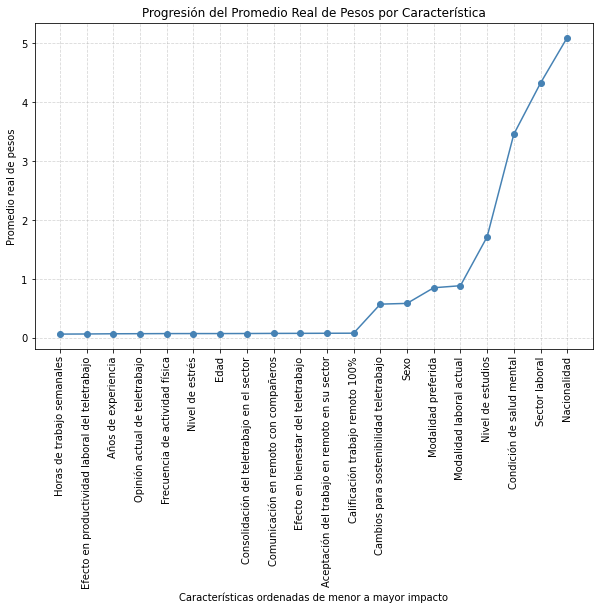

In [42]:
# Ordenar los valores de pesos agrupados de menor a mayor
pesos_ordenados = pesos_agrupados.sort_values(ascending=True)

plt.figure(figsize=(10, 6))

# Graficar la l√≠nea con los valores ordenados
plt.plot(pesos_ordenados.values, marker='o', linestyle='-', color='steelblue')

# A√±adir etiquetas de caracter√≠sticas y t√≠tulo
plt.xticks(range(len(pesos_ordenados)), pesos_ordenados.index, rotation=90)
plt.xlabel("Caracter√≠sticas ordenadas de menor a mayor impacto")
plt.ylabel("Promedio real de pesos")
plt.title("Progresi√≥n del Promedio Real de Pesos por Caracter√≠stica")
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar el gr√°fico
plt.show()

In [43]:
# Crear un diccionario que mapea cada columna codificada a su variable original
mapeo_vars = {}

cols_codificadas = X.columns.tolist()

# Para OneHotEncoded: buscar las columnas que comienzan con cada variable original
for col in columnas_categoricas_onehotEncoding:
    prefijo = col + '_'
    for c in cols_caracteristicas:
        if c.startswith(prefijo):
            mapeo_vars[c] = col

# Para LabelEncoded: una columna corresponde a una variable
for col in columnas_categoricas_labelEncoding:
    if col in cols_caracteristicas:
        mapeo_vars[col] = col

# Para las dem√°s columnas num√©ricas
for col in cols_caracteristicas:
    if col not in mapeo_vars:
        mapeo_vars[col] = col 

# Crear DataFrame con pesos
df_pesos = pd.DataFrame(
    pesos_entrada,
    index=cols_codificadas,
    columns=[f"Neurona_{j+1}" for j in range(pesos_entrada.shape[1])]
)

# Calcular el promedio de pesos absolutos por caracter√≠stica codificada
pesos = df_pesos.mean(axis=1)

# Agrupar por variable original
pesos_agrupados = pesos.groupby(mapeo_vars).sum().sort_values(ascending=True)

print("Promedio real de pesos en variables categ√≥ricas y num√©ricas (agrupadas por caracter√≠sticas):\n")
print(pesos_agrupados)

Promedio real de pesos en variables categ√≥ricas y num√©ricas (agrupadas por caracter√≠sticas):

Sector laboral                                    -0.115635
Nacionalidad                                      -0.105120
Nivel de estudios                                 -0.022146
Efecto en productividad laboral del teletrabajo   -0.010909
Modalidad laboral actual                          -0.009307
Consolidaci√≥n del teletrabajo en el sector        -0.005085
Modalidad preferida                               -0.002992
Opini√≥n actual de teletrabajo                     -0.002798
Comunicaci√≥n en remoto con compa√±eros             -0.002520
Frecuencia de actividad f√≠sica                    -0.002329
Horas de trabajo semanales                        -0.002245
Calificaci√≥n trabajo remoto 100%                  -0.002104
Sexo                                              -0.001193
Efecto en bienestar del teletrabajo                0.000989
Nivel de estr√©s                                    0.001

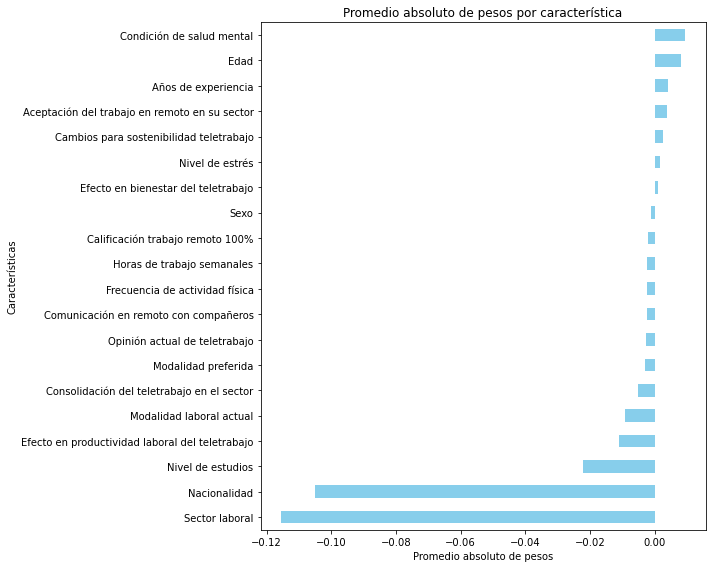

In [44]:
plt.figure(figsize=(10, 8))

# Graficar las barras de pesos
pesos_agrupados.plot(kind="barh", color="skyblue")

# A√±adir etiquetas de caracter√≠sticas y t√≠tulo
plt.xlabel("Promedio absoluto de pesos")
plt.ylabel("Caracter√≠sticas")
plt.title("Promedio absoluto de pesos por caracter√≠stica")
plt.tight_layout()

# Mostrar el gr√°fico
plt.show()

### 7. Guardar predicciones en un nuevo dataset:

In [45]:
archivo_excel = 'Dataset_updated (predicciones).xlsx'

# Si el archivo ya existe, eliminarlo para poder reemplazarlo
if os.path.exists(archivo_excel):
    os.remove(archivo_excel)

# Exportar el DataFrame a un archivo Excel
df_pred.to_excel(archivo_excel, index=False)
print("El archivo Excel se ha creado exitosamente, reemplazando el anterior.")

El archivo Excel se ha creado exitosamente, reemplazando el anterior.


### 8. Evaluaci√≥n de los valores predichos frente a los valores reales:

#### 8.1. Identificaci√≥n de desviaciones en el modelo.

La l√≠nea roja representa la correspondencia ideal entre las predicciones y los valores reales. Cuanto m√°s se acerquen los puntos azules a la l√≠nea que muestra la ecuaci√≥n "y=x", mejor ser√° el rendimiento del modelo. Adem√°s, y[col] son los valores reales para la variable 'col' en todo el dataset e y_pred_total[:, i] son las predicciones agregadas para esa misma variable.

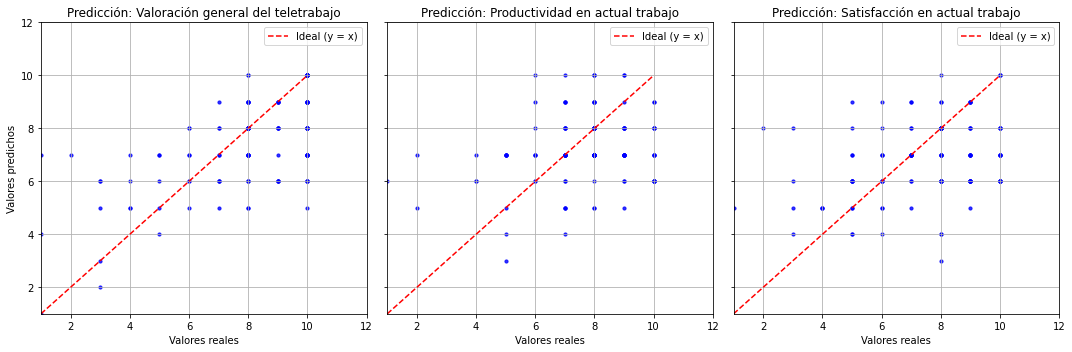

In [46]:
fig, axes = plt.subplots(1, len(variables_objetivo), figsize=(15, 5), sharey=True)

for i, (col, ax) in enumerate(zip(variables_objetivo, axes)):
    
    ax.scatter(y[col], y_pred_total[:, i], alpha=0.8, color='blue', s=10, marker='o')
    
    # Dibujar la l√≠nea ideal (y = x)
    ax.plot([1, 10], [1, 10], color='red', linestyle='--', label="Ideal (y = x)")
    
    ax.set_xlabel("Valores reales")
    ax.set_title(f"Predicci√≥n: {col}")
    ax.set_xlim(1, 12)
    ax.set_ylim(1, 12)
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Valores predichos")
plt.tight_layout()

# Mostrar el gr√°fico
plt.show()

#### 8.2. Distribuci√≥n de residuos.

El modelo est√° capturando de manera correcta la tendencia de los datos, puesto que los errores se distribuyen aleatoriamente alrededor de cero, formando una campana de Gauss.

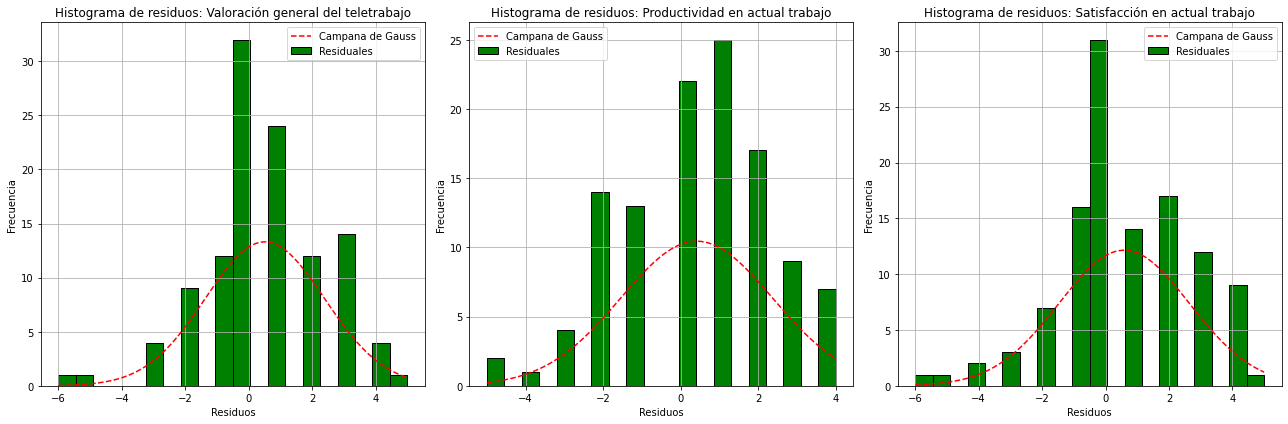

In [47]:
# Crear subgr√°ficas (una por cada variable objetivo)
fig, axes = plt.subplots(1, len(variables_objetivo), figsize=(6 * len(variables_objetivo), 6))

for i, col in enumerate(variables_objetivo):
    # Calcular los residuos: diferencia entre los valores reales y las predicciones
    residuales = y[col].values - y_pred_total[:, i]
    
    ax = axes[i]

    # Graficar el histograma de residuos
    n, bins, patches = ax.hist(residuales, bins=20, color='green', edgecolor='black', label="Residuales")
    
    # Calcular la anchura de las barras del histograma
    bin_width = bins[1] - bins[0]
    
    # Calcular la media y la desviaci√≥n est√°ndar de los residuos
    mean_ = np.mean(residuales)
    std_ = np.std(residuales)
    
    # Generar valores x que cubran el rango de datos para la curva de Gauss
    x_vals = np.linspace(bins[0], bins[-1], 100)
    
    # Calcular la la campana de Gauss y escalarla para ajustarla al histograma
    y_gauss = norm.pdf(x_vals, mean_, std_) * len(residuales) * bin_width
    
    # Dibujar la campana de Gauss sobre el histograma
    ax.plot(x_vals, y_gauss, 'r--', label="Campana de Gauss")
    ax.set_xlabel("Residuos")
    ax.set_ylabel("Frecuencia")
    ax.set_title(f"Histograma de residuos: {col}")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

#### 8.3. Diagramas de caja.

La distribuci√≥n de los valores reales con los predichos es pr√°cticamente igual, por lo que el modelo ha capturado de manera adecuada la variabilidad de las variables objetivo.

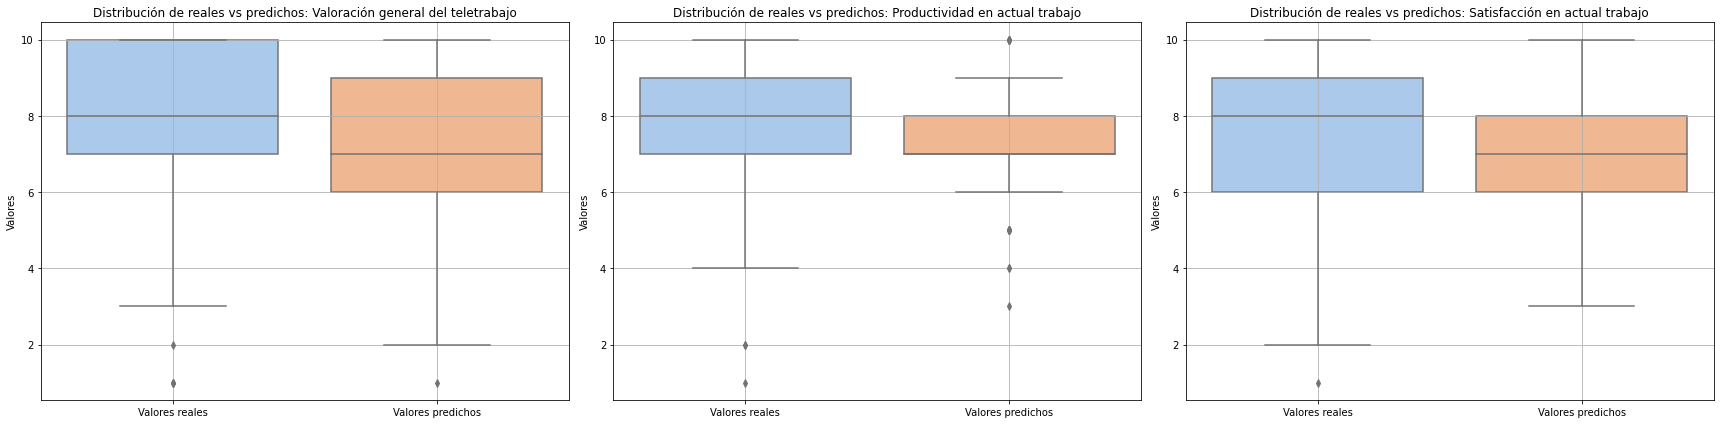

In [48]:
# Crear subgr√°ficas: una por cada variable objetivo
fig, axes = plt.subplots(1, len(variables_objetivo), figsize=(8 * len(variables_objetivo), 6))

for i, col in enumerate(variables_objetivo):
    ax = axes[i]  
    
    # Usar los valores reales del conjunto de entrenamiento y las predicciones acumuladas (y_pred_total)
    sns.boxplot(data=[y[col].values, y_pred_total[:, i]], palette="pastel", ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Valores reales", "Valores predichos"])
    ax.set_ylabel("Valores")
    ax.set_title(f"Distribuci√≥n de reales vs predichos: {col}")
    ax.grid(True)

plt.tight_layout()
plt.show()

### 9. Generaci√≥n de nuevos DataFrames:

#### 9.1. Combinar conjuntos de datos - df_pred y df_original.

Se juntan los registros con las predicciones (df_pred) con los registros sin los valores nulos en las variables objetivo (df_original).

In [49]:
df_original = df_original.dropna(subset=variables_objetivo)

In [50]:
# Reemplazar las filas en df_modif correspondientes a los registros predichos
df_modif.loc[df_pred.index, variables_objetivo] = df_predicciones[variables_objetivo]

In [51]:
display(df_modif.head())

id  Edad  A√±os de experiencia  Horas de trabajo semanales  \
0   1    22                  1.5                         8.0   
1   2    41                 20.0                        48.0   
2   3    22                  2.0                        30.0   
3   4    22                  1.0                        43.0   
4   5    23                  1.0                        40.0   

   Opini√≥n actual de teletrabajo  Calificaci√≥n trabajo remoto 100%  \
0                              2                                 2   
1                              2                                 2   
2                              3                                 3   
3                              3                                 2   
4                              1                                 1   

   Aceptaci√≥n del trabajo en remoto en su sector Nivel de estr√©s  \
0                                              3        B. Medio   
1                                              3        B. Medio   
2                                              3         C. Bajo   
3                                              3        B. Medio   
4                                              3         C. Bajo   

  Frecuencia de actividad f√≠sica  \
0           D. 1 d√≠a a la semana   
1           D. 1 d√≠a a la semana   
2           D. 1 d√≠a a la semana   
3                    E. Rara vez   
4           D. 1 d√≠a a la semana   

   Efecto en productividad laboral del teletrabajo  ...  \
0                                                2  ...   
1                                                1  ...   
2                                                2  ...   
3                                                2  ...   
4                                                2  ...   

   Productividad en actual trabajo  Satisfacci√≥n en actual trabajo    Sexo  \
0                              8.0                             7.0  Hombre   
1                              8.0                             8.0  Hombre   
2                              7.0                             8.0  Hombre   
3                              7.0                             7.0  Hombre   
4                              7.0                             8.0  Hombre   

   Nacionalidad        Nivel de estudios        Sector laboral  \
0      Espa√±ola  Estudios universitarios  Tecnolog√≠a y Ciencia   
1      Espa√±ola    Estudios de postgrado  Tecnolog√≠a y Ciencia   
2      Espa√±ola  Estudios universitarios  Tecnolog√≠a y Ciencia   
3      Espa√±ola  Estudios universitarios  Tecnolog√≠a y Ciencia   
4      Espa√±ola  Estudios universitarios  Tecnolog√≠a y Ciencia   

  Modalidad laboral actual Condici√≥n de salud mental Modalidad preferida  \
0                  H√≠brido   Sin problema espec√≠fico             H√≠brido   
1                   Remoto                   Burnout             H√≠brido   
2                  H√≠brido   Sin problema espec√≠fico             H√≠brido   
3                   Remoto   Sin problema espec√≠fico             H√≠brido   
4                  H√≠brido   Sin problema espec√≠fico     Presencial 100%   

  Cambios para sostenibilidad teletrabajo  
0                                      No  
1                                      S√≠  
2                                      No  
3                                      S√≠  
4                                      S√≠  

[5 rows x 24 columns]

#### 9.2. Creaci√≥n de un nuevo dataset.

Finalmente, se crea un nuevo conjunto de datos que contiene todos los registros iniciales, los que ten√≠an valor en cada una de las variables objetivo, junto con las filas de los valores que se han predicho.

In [52]:
archivo_excel1 = 'Dataset_completo.xlsx'

# Si el archivo ya existe, eliminarlo para poder reemplazarlo
if os.path.exists(archivo_excel1):
    os.remove(archivo_excel1)

# Exportar el DataFrame a un archivo Excel
df_modif.to_excel(archivo_excel1, index=False)
print("El archivo Excel se ha creado exitosamente, reemplazando el anterior.")

El archivo Excel se ha creado exitosamente, reemplazando el anterior.


### 10. Contraste de hip√≥tesis:

#### 10.1. Impacto de la valoraci√≥n general del teletrabajo sobre la Productividad y Satisfacci√≥n.

Se ha decidido segmentar el an√°lisis seg√∫n la modalidad laboral actual (remota, presencial o h√≠brida) para distinguir las diferencias en las correlaciones espec√≠ficas de cada din√°mica, tratando de evitar conclusiones incorrectas. 

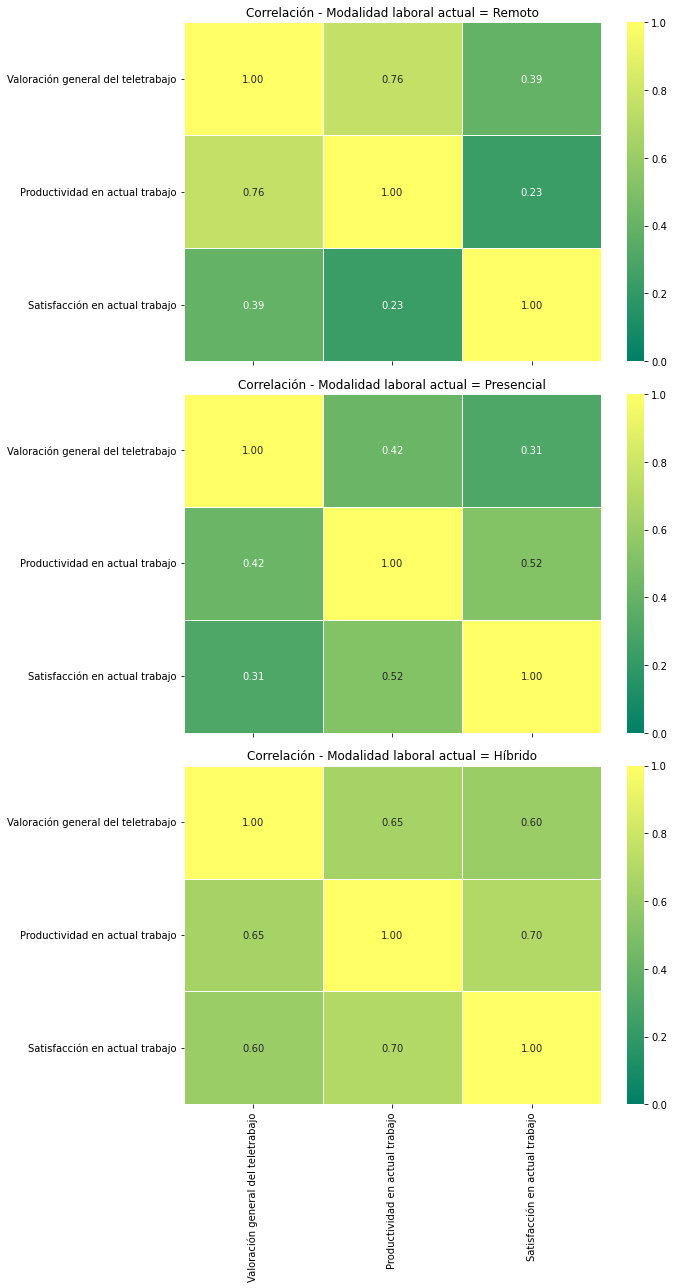

In [53]:
# Lista de variables de inter√©s para el heatmap
variables_interes = [
    "Valoraci√≥n general del teletrabajo",
    "Productividad en actual trabajo",
    "Satisfacci√≥n en actual trabajo"
]

# Filtrar por cada modalidad
df_remoto = df_modif[df_modif["Modalidad laboral actual"] == "Remoto"][variables_interes]
df_presencial = df_modif[df_modif["Modalidad laboral actual"] == "Presencial"][variables_interes]
df_hibrido = df_modif[df_modif["Modalidad laboral actual"] == "H√≠brido"][variables_interes]

# Crear figura con tres subplots verticales
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Heatmap para la modalidad Remoto
sns.heatmap(
    df_remoto.corr(), 
    annot=True, cmap="summer", vmin=0, vmax=1, fmt=".2f", linewidths=0.5, 
    ax=axes[0]
)
axes[0].set_title("Correlaci√≥n - Modalidad laboral actual = Remoto")
axes[0].set_xticklabels([])  # Eliminar etiquetas del eje X

# Heatmap para la modalidad Presencial
sns.heatmap(
    df_presencial.corr(), 
    annot=True, cmap="summer", vmin=0, vmax=1, fmt=".2f", linewidths=0.5, 
    ax=axes[1]
)
axes[1].set_title("Correlaci√≥n - Modalidad laboral actual = Presencial")
axes[1].set_xticklabels([])  # Eliminar etiquetas del eje X

# Heatmap para la modalidad H√≠brido (se mantienen las etiquetas del eje X)
sns.heatmap(
    df_hibrido.corr(), 
    annot=True, cmap="summer", vmin=0, vmax=1, fmt=".2f", linewidths=0.5, 
    ax=axes[2]
)
axes[2].set_title("Correlaci√≥n - Modalidad laboral actual = H√≠brido")

# Mostrar el gr√°fico
plt.tight_layout()
plt.show()

#### 10.2. Asignaci√≥n de pesos en la predicci√≥n de la satisfacci√≥n laboral.

El objetivo es comprender c√≥mo se asocian las diferentes caracter√≠sticas con el nivel de satisfacci√≥n mediante un modelo que asigna coeficientes espec√≠ficos a cada predictor, permitiendo cuantificar el impacto individual sobre las variables dependientes.

In [54]:
# Variables
X = df_modif[['Modalidad laboral actual', 'Edad', 'Sexo', 'Nacionalidad', 'A√±os de experiencia']]
y = df_modif['Satisfacci√≥n en actual trabajo']

# Columnas categ√≥ricas y num√©ricas
cat_features = ['Modalidad laboral actual', 'Sexo', 'Nacionalidad']
num_features = ['Edad', 'A√±os de experiencia']

# Preprocesamiento con OneHotEncoder y generaci√≥n de interacciones
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), cat_features),
    ('num', 'passthrough', num_features)
])

# Generaci√≥n de interacciones con PolynomialFeatures
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Pipeline que integra preprocesamiento, creaci√≥n de interacciones y regresi√≥n lineal
model = Pipeline([
    ('preprocessor', preprocessor),
    ('interactions', interaction),
    ('regressor', LinearRegression())
])

# Entrenar el modelo
model.fit(X, y)

# Extraer nombres de las caracter√≠sticas despu√©s de aplicar las interacciones
nombres_caracteristicas = model.named_steps['interactions'].get_feature_names_out(
    caracteristicas_entrada=model.named_steps['preprocessor'].get_feature_names_out()
)

# Crear DataFrame con coeficientes asociados a cada feature
coef_df = pd.DataFrame({
    'caracteristica': caracteristicas_entrada,
    'coeficiente': model.named_steps['regressor'].coef_
})

# Ordenar las features por la magnitud de sus coeficientes
coef_df = coef_df.sort_values(by='coeficiente', key=abs, ascending=False)

# Excluir las caracter√≠sticas, cuyo coeficiente es 0
coef_df_filtrado = coef_df[coef_df['coeficiente'] != 0]
print(coef_df_filtrado)

# Guardar el DataFrame filtrado en un archivo Excel
coef_df_filtrado.to_excel('coef_df_filtrado.xlsx', index=False)

print("El DataFrame se ha guardado en 'coef_df_filtrado.xlsx'")

                                        caracteristica  coeficiente
8                         cat__Nacionalidad_Colombiana     7.065329
4                          cat__Nacionalidad_Argentina    -6.012938
67         cat__Sexo_Mujer cat__Nacionalidad_Argentina    -6.012938
39   cat__Modalidad laboral actual_Presencial cat__...    -5.470920
20                        cat__Nacionalidad_Venezolana     5.363856
..                                                 ...          ...
19                            cat__Nacionalidad_Rumana     0.004058
82            cat__Sexo_Mujer cat__Nacionalidad_Rumana     0.004058
272  cat__Nacionalidad_Rumana num__A√±os de experiencia     0.004058
41   cat__Modalidad laboral actual_Presencial cat__...     0.004058
275                 num__Edad num__A√±os de experiencia    -0.000338

[110 rows x 2 columns]
El DataFrame se ha guardado en 'coef_df_filtrado.xlsx'


In [55]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Obtener el intercepto
intercepto = modelo.intercept_
print("Intercepto del modelo:", intercepto)

Intercepto del modelo: [7.85579762 7.70853636 7.46167954]


#### 10.3. Adaptabilidad y preferencias sobre las distintas modalidades laborales.

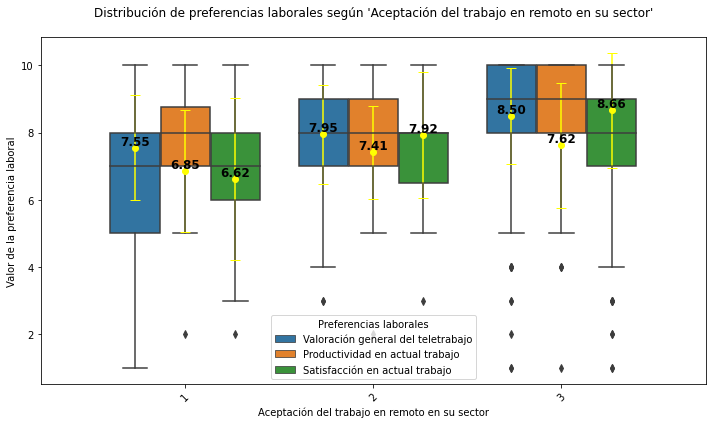

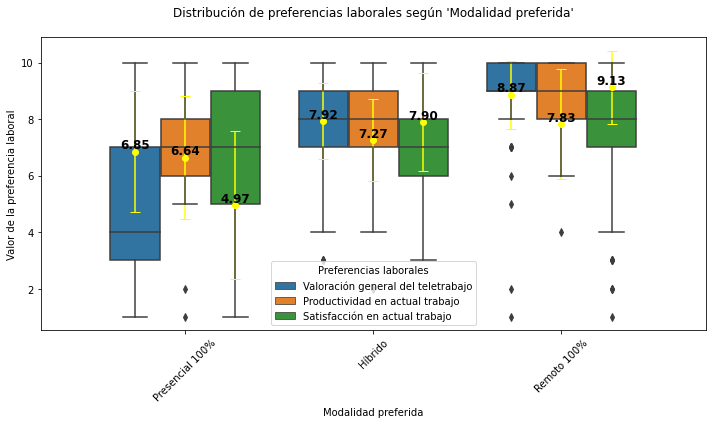

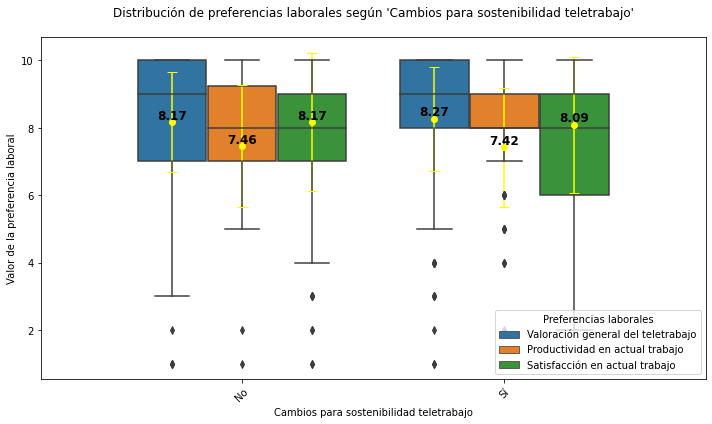

In [67]:
# Define las variables independientes (categ√≥ricas) y los outcomes
independent_vars = [
    "Aceptaci√≥n del trabajo en remoto en su sector", 
    "Modalidad preferida", 
    "Cambios para sostenibilidad teletrabajo"
]
outcome_vars = [
    "Valoraci√≥n general del teletrabajo", 
    "Productividad en actual trabajo", 
    "Satisfacci√≥n en actual trabajo"
]

# Recorrer cada variable independiente para graficarla
for iv in independent_vars:
    
    # Convertir a formato long para facilitar la comparaci√≥n
    df_long = pd.melt(df_modif, 
                      id_vars=[iv], 
                      value_vars=outcome_vars, 
                      var_name="Preferencias laborales", 
                      value_name="Valor")
    
    plt.figure(figsize=(10, 6))

    # Definir el orden deseado para la variable "Modalidad preferida"
    if iv == "Modalidad preferida":
        cat_order = ["Presencial 100%", "H√≠brido", "Remoto 100%"]
    else:
        cat_order = sorted(df_long[iv].unique())

    ax = sns.boxplot(x=iv, y="Valor", hue="Preferencias laborales", data=df_long, order=cat_order)

    # Calcular estad√≠sticas
    stats = df_long.groupby([iv, "Preferencias laborales"])["Valor"].agg(["mean", "std"]).reset_index()

    # Obtener el orden de los niveles para posicionar las medias y desviaciones
    hue_order = sorted(df_long["Preferencias laborales"].unique())
    n_hues = len(hue_order)
    dodge = 0.4
    box_width = (2 * dodge) / n_hues

    # Ubicar correctamente los puntos sobre el gr√°fico de cajas
    for idx, row in stats.iterrows():
        cat = row[iv]
        hue_val = row["Preferencias laborales"]
        cat_idx = cat_order.index(cat)
        hue_idx = hue_order.index(hue_val)
        x_pos = cat_idx - dodge + (hue_idx + 0.5) * box_width

        # Etiqueta de media
        ax.text(x_pos, row["mean"], f"{row['mean']:.2f}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
        
        # A√±adir punto de la media y barra de error
        ax.errorbar(x=x_pos, y=row["mean"], yerr=row["std"], fmt='o', color='yellow', capsize=5)

    # Ajustar leyenda
    handles, labels = ax.get_legend_handles_labels()
    unique_labels, unique_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)

    plt.title(f"Distribuci√≥n de preferencias laborales seg√∫n '{iv}'\n")
    plt.xlabel(iv)
    plt.ylabel("Valor de la preferencia laboral")
    plt.xticks(rotation=45)
    ax.legend(unique_handles, unique_labels, title="Preferencias laborales", loc="best")
    plt.tight_layout()
    
    # Mostrar el gr√°fico
    plt.show()

La desviaci√≥n est√°ndar (l√≠nea de color amarillo) indica la variabilidad en los datos alrededor de la media. Cuanto mayor sean estas l√≠neas, mayor ser√° la dispersi√≥n de los datos, lo que significa que hay m√°s variabilidad en c√≥mo los trabajadores perciben su productividad y satisfacci√≥n en las din√°micas laborales.

#### 10.4. Impacto del nivel de estr√©s, la condici√≥n de salud mental y la frecuencia de actividad f√≠sica.

El objetivo es observar el impacto de la productividad en la valoraci√≥n del teletrabajo, sin excluir la necesidad de prestar atenci√≥n al manejo del estr√©s, al cuidado de la salud mental y al inicio de h√°bitos saludables como la actividad f√≠sica.

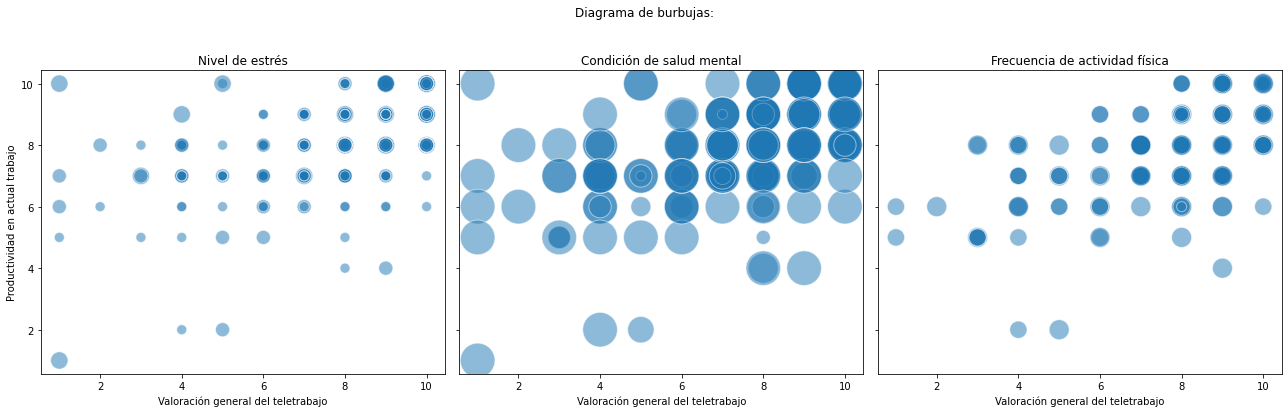

In [73]:
# Variables a usar
vars_ = ["Nivel de estr√©s", "Condici√≥n de salud mental", "Frecuencia de actividad f√≠sica"]
x_var = "Valoraci√≥n general del teletrabajo"
y_var = "Productividad en actual trabajo"

# Crear el diagrama de burbujas
fig, axes = plt.subplots(1, len(vars_), figsize=(18, 6), sharex=True, sharey=True)

for i, w in enumerate(vars_):
    
    # Determinar el tama√±o de las burbujas en funci√≥n de la variable de bienestar
    if pd.api.types.is_numeric_dtype(df_modif[w]):
        bubble_sizes = df_completo[w].copy()
        scaling_factor = 50  # Ajusta este factor seg√∫n convenga
        bubble_sizes = bubble_sizes * scaling_factor
    else:
        
        # Convertir la variable categ√≥rica a c√≥digos num√©ricos
        bubble_sizes = pd.Categorical(df_modif[w]).codes.astype(float)
        scaling_factor = 100  # Factor de escalado para variables categ√≥ricas
        bubble_sizes = bubble_sizes * scaling_factor

    ax = axes[i]
    sc = ax.scatter(df_modif[x_var], df_modif[y_var], 
                    s=bubble_sizes,       # Tama√±o de la burbuja
                    alpha=0.5, 
                    edgecolors='w')

    ax.set_title(w)
    ax.set_xlabel(x_var)
    if i == 0:
        ax.set_ylabel(y_var)

plt.suptitle("Diagrama de burbujas:")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()